In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import plotly.express as px
import warnings
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from pathlib import Path
from sklearn.metrics import adjusted_rand_score

warnings.filterwarnings("ignore")


In [2]:
# Initialize workflow parameters
num_top = 50
data_path = Path(f'../data/top_{num_top}_companies_by_sector.csv').resolve()
analysis_start = "2024-01-01"
analysis_end = "2025-05-15"
data = pd.read_csv(data_path)
data

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap (B),Country,IPO Year,Volume,Sector,Industry
0,UFPI,UFP Industries Inc. Common Stock,$115.67,-0.7900,-0.678%,7.024022,United States,1993.0,223820,Basic Materials,Forest Products
1,AMWD,American Woodmark Corporation Common Stock,$77.01,0.4800,0.627%,1.159322,United States,1986.0,168642,Basic Materials,Forest Products
2,IPX,IperionX Limited American Depositary Share,$26.52,0.1200,0.455%,0.682213,United States,NaN,50560,Basic Materials,Other Metals and Minerals
3,EU,enCore Energy Corp. Common Shares,$2.91,0.0600,2.105%,0.541518,United States,NaN,1091464,Basic Materials,Other Metals and Minerals
4,USGO,U.S. GoldMining Inc. Common stock,$12.59,1.7800,16.466%,0.156678,United States,2023.0,225247,Basic Materials,Precious Metals
...,...,...,...,...,...,...,...,...,...,...,...
524,VIVK,Vivakor Inc. Common Stock,$0.845,-0.0248,-2.851%,0.028424,United States,NaN,42549,Utilities,Environmental Services
525,SONM,Sonim Technologies Inc. Common Stock,$2.55,-0.0800,-3.042%,0.012423,United States,2019.0,15396,Utilities,Telecommunications Equipment
526,CLRO,ClearOne Inc. (DE) Common Stock,$0.4926,-0.0072,-1.441%,0.011807,United States,NaN,87213,Utilities,Telecommunications Equipment
527,SUNE,SUNation Energy Inc. Common Stock,$1.225,-0.0950,-7.197%,0.002223,United States,NaN,87057,Utilities,Telecommunications Equipment


In [3]:
ticker = data['Symbol'].to_list()
company_name_ticker = data[['Name', 'Symbol']]
market_ticker = '^GSPC'
ticker.append(market_ticker)
company_name_ticker

,Name,Symbol
0,UFP Industries Inc. Common Stock,UFPI
1,American Woodmark Corporation Common Stock,AMWD
2,IperionX Limited American Depositary Share,IPX
3,enCore Energy Corp. Common Shares,EU
4,U.S. GoldMining Inc. Common stock,USGO
...,...,...
524,Vivakor Inc. Common Stock,VIVK
525,Sonim Technologies Inc. Common Stock,SONM
526,ClearOne Inc. (DE) Common Stock,CLRO
527,SUNation Energy Inc. Common Stock,SUNE


In [4]:
stock_price = yf.download(tickers=ticker, start = analysis_start, end = analysis_end)['Close'].dropna(axis = 1)
stock_price

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  530 of 530 completed

21 Failed downloads:
['DHCNL', 'ARKOW', 'SLDPW', 'AMODW', 'NXPLW', 'NEHCW', 'USGOW', 'ADNWW', 'NESRW', 'MVSTW', 'FOXXW', 'ANNAW', 'NIOBW', 'RMCOW', 'ZEOWW', 'HYMCW', 'NEOVW', 'DFLIW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-01-01 -> 2025-05-15)')
['INFN', 'ROIC']: HTTPError('HTTP Error 404: ')
['QRTEP']: YFTzMissingError('possibly delisted; no timezone found')


Ticker,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,13.44,73.545914,184.290421,4.405,134.479996,7.980,3.92,580.070007,189.526352,6.600,...,37.200630,57.250000,267.980011,67.309998,11.26,56.220001,41.883698,69.150002,212.369995,4742.830078
2024-01-03,12.95,72.759697,182.910538,4.230,133.419998,7.950,3.89,571.789978,185.003098,6.150,...,36.628452,55.230000,252.520004,65.860001,11.28,53.980000,39.853088,67.169998,210.240005,4704.810059
2024-01-04,13.09,73.386673,180.587540,4.250,133.720001,7.640,3.82,567.049988,182.173630,6.000,...,36.250248,54.160000,252.970001,65.570000,11.27,52.750000,40.460377,66.900002,210.330002,4688.680176
2024-01-05,13.60,72.102859,179.862823,4.150,135.979996,8.000,3.84,564.599976,182.643570,5.910,...,35.901123,53.709999,252.690002,65.160004,11.27,52.430000,41.798298,66.959999,209.809998,4697.240234
2024-01-08,14.58,73.346870,184.211014,4.120,140.080002,7.950,3.89,580.549988,185.022675,5.940,...,36.153259,55.669998,261.089996,66.650002,11.28,54.580002,42.263248,68.389999,218.100006,4763.540039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,11.03,99.430000,197.231369,1.410,126.389999,3.975,3.54,383.989990,202.779999,3.340,...,32.689999,67.900002,265.369995,32.380001,1.60,66.750000,46.364128,80.250000,233.149994,5663.939941
2025-05-09,11.11,100.230003,198.270004,1.400,127.040001,4.400,3.77,383.279999,207.509995,2.800,...,32.790001,67.930000,266.709991,30.910000,1.67,66.779999,46.106380,81.309998,233.059998,5659.910156
2025-05-12,11.67,104.629997,210.789993,1.340,134.210007,4.940,3.89,395.940002,223.149994,2.740,...,32.099998,71.209999,300.109985,34.700001,1.57,70.080002,49.030781,82.669998,241.479996,5844.189941


In [5]:
returns = stock_price.pct_change().dropna()
ticker = [col for col in stock_price.columns if col != market_ticker]
stock_returns = returns[ticker]
market_returns = returns[market_ticker]
stock_returns

Ticker,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-03,-0.036458,-0.010690,-0.007488,-0.039728,-0.007882,-0.003759,-0.007653,-0.014274,-0.023866,-0.068182,...,0.015968,-0.015381,-0.035284,-0.057691,-0.021542,0.001776,-0.039844,-0.048482,-0.028633,-0.010030
2024-01-04,0.010811,0.008617,-0.012700,0.004728,0.002249,-0.038994,-0.017995,-0.008290,-0.015294,-0.024390,...,0.023576,-0.010325,-0.019374,0.001782,-0.004403,-0.000886,-0.022786,0.015238,-0.004020,0.000428
2024-01-05,0.038961,-0.017494,-0.004013,-0.023529,0.016901,0.047120,0.005236,-0.004321,0.002580,-0.015000,...,-0.007678,-0.009631,-0.008309,-0.001107,-0.006253,0.000000,-0.006066,0.033067,0.000897,-0.002472
2024-01-08,0.072059,0.017253,0.024175,-0.007229,0.030152,-0.006250,0.013021,0.028250,0.013026,0.005076,...,-0.015474,0.007023,0.036492,0.033242,0.022867,0.000887,0.041007,0.011124,0.021356,0.039512
2024-01-09,-0.013717,-0.013840,-0.002263,-0.007281,-0.003926,-0.015094,0.000000,0.009732,0.004127,0.010101,...,0.021611,-0.010998,-0.004131,-0.017810,-0.018305,0.000000,-0.004214,-0.011226,-0.001170,0.037414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,0.044508,0.038867,0.006319,0.052239,0.026559,-0.058057,0.153094,-0.002546,0.014610,-0.005952,...,0.062356,-0.014768,0.000295,0.031444,0.023712,-0.030303,0.004666,0.030403,0.020473,-0.001670
2025-05-09,0.007253,0.008046,0.005266,-0.007092,0.005143,0.106918,0.064972,-0.001849,0.023326,-0.161677,...,0.097826,0.003059,0.000442,0.005050,-0.045398,0.043750,0.000449,-0.005559,0.013209,-0.000386
2025-05-12,0.050405,0.043899,0.063146,-0.042857,0.056439,0.122727,0.031830,0.033031,0.075370,-0.021429,...,-0.014851,-0.021043,0.048285,0.125230,0.122614,-0.059880,0.049416,0.063427,0.016726,0.036128


In [6]:
sector_stocks = data[['Symbol', 'Sector']]
sector_stocks_cleaned = sector_stocks[sector_stocks['Symbol'].apply(lambda x: x in ticker)]
sector_stocks_cleaned_with_name = pd.merge(sector_stocks_cleaned, company_name_ticker, left_on='Symbol', right_on = 'Symbol')
sector_stocks_cleaned_with_name

,Symbol,Sector,Name
0,UFPI,Basic Materials,UFP Industries Inc. Common Stock
1,AMWD,Basic Materials,American Woodmark Corporation Common Stock
2,IPX,Basic Materials,IperionX Limited American Depositary Share
3,EU,Basic Materials,enCore Energy Corp. Common Shares
4,USGO,Basic Materials,U.S. GoldMining Inc. Common stock
...,...,...,...
494,VIVK,Utilities,Vivakor Inc. Common Stock
495,SONM,Utilities,Sonim Technologies Inc. Common Stock
496,CLRO,Utilities,ClearOne Inc. (DE) Common Stock
497,SUNE,Utilities,SUNation Energy Inc. Common Stock


In [7]:
residuals = pd.DataFrame(index=stock_returns.index)
for tick in ticker:
    Y = stock_returns[tick]
    X = sm.add_constant(market_returns)
    model = sm.OLS(Y, X).fit()
    residuals[tick] = model.resid
# calculating the residual return 
resid_corr = residuals.corr()
resid_corr

,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
AAL,1.000000,0.045487,0.013940,0.062087,0.166405,0.018780,0.112186,-0.015802,0.123420,-0.038666,...,-0.015179,-0.021215,0.030480,0.231893,0.111321,-0.093232,0.034995,0.206322,0.033978,-0.027073
AAON,0.045487,1.000000,-0.244485,0.006797,-0.100677,0.032723,0.121121,-0.064526,-0.042473,-0.002442,...,0.004188,0.018463,0.014137,0.128257,0.110078,0.001087,0.012347,0.072648,0.034495,0.071909
AAPL,0.013940,-0.244485,1.000000,0.022736,0.032831,0.009754,0.022072,-0.025251,0.022508,-0.025851,...,-0.020584,-0.009895,-0.016633,-0.035816,0.020581,0.079602,-0.017742,-0.110754,0.007773,0.002507
ABAT,0.062087,0.006797,0.022736,1.000000,0.026815,0.017245,-0.000058,-0.005761,0.006238,0.100489,...,-0.055443,-0.002327,0.016923,0.018469,0.041217,-0.000568,0.021040,-0.000368,0.097028,0.008665
ABNB,0.166405,-0.100677,0.032831,0.026815,1.000000,-0.030687,0.032206,0.068934,0.120943,0.024653,...,0.230475,-0.074382,0.092531,0.137449,-0.019965,0.051326,0.104024,0.036202,0.112238,-0.008373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEO,-0.093232,0.001087,0.079602,-0.000568,0.051326,0.000623,-0.008191,0.052408,0.087195,0.053508,...,0.074813,-0.019882,0.054418,0.010211,-0.028127,1.000000,0.043804,0.065110,0.001231,-0.009860
ZG,0.034995,0.012347,-0.017742,0.021040,0.104024,-0.063113,-0.023237,0.071467,-0.058643,0.162917,...,-0.016456,0.050418,0.994947,0.030787,0.131158,0.043804,1.000000,-0.016126,0.086628,0.050909
ZION,0.206322,0.072648,-0.110754,-0.000368,0.036202,0.201502,0.249320,-0.072213,0.061608,0.052685,...,-0.071120,0.188690,-0.010364,0.299802,0.265550,0.065110,-0.016126,1.000000,0.103131,0.085399
ZM,0.033978,0.034495,0.007773,0.097028,0.112238,0.072688,0.072347,0.096368,0.000775,0.082414,...,-0.004736,0.047405,0.082223,0.028048,0.214495,0.001231,0.086628,0.103131,1.000000,0.265072


In [8]:
threshold = 0.03
n_tsne_component = 2
n_cluster = 12
n_pca_component = 2

pca_model = PCA(n_components=n_pca_component)
pca_output = pca_model.fit_transform(resid_corr.values)
tsne = TSNE(n_components=n_tsne_component, perplexity=15, init='random', random_state=42)
embedding = tsne.fit_transform(pca_output)
kmeans = KMeans(n_clusters=n_cluster, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)

In [9]:
df_tsne = pd.DataFrame({
    'Symbol': ticker,
    'PC1': embedding[:,0],
    'PC2': embedding[:,1],
    'clusters': cluster_labels
})
df_tsne

,Symbol,PC1,PC2,clusters
0,AAL,28.926487,-11.991823,8
1,AAON,13.334380,26.707693,5
2,AAPL,-26.599424,13.756914,10
3,ABAT,-7.785661,39.699909,3
4,ABNB,10.190524,25.343948,5
...,...,...,...,...
494,ZEO,-10.433044,28.561325,3
495,ZG,-15.826549,8.287899,10
496,ZION,25.446459,-37.982716,2
497,ZM,3.917749,-7.329438,4


In [10]:
merged_tsne = pd.merge(df_tsne, sector_stocks_cleaned_with_name, right_on = 'Symbol', left_on = 'Symbol')
merged_tsne

,Symbol,PC1,PC2,clusters,Sector,Name
0,AAL,28.926487,-11.991823,8,Consumer Discretionary,American Airlines Group Inc. Common Stock
1,AAON,13.334380,26.707693,5,Industrials,AAON Inc. Common Stock
2,AAPL,-26.599424,13.756914,10,Technology,Apple Inc. Common Stock
3,ABAT,-7.785661,39.699909,3,Basic Materials,American Battery Technology Company Common Stock
4,ABNB,10.190524,25.343948,5,Finance,Airbnb Inc. Class A Common Stock
...,...,...,...,...,...,...
494,ZEO,-10.433044,28.561325,3,Miscellaneous,Zeo Energy Corporation Class A Common Stock
495,ZG,-15.826549,8.287899,10,Consumer Discretionary,Zillow Group Inc. Class A Common Stock
496,ZION,25.446459,-37.982716,2,Finance,Zions Bancorporation N.A. Common Stock
497,ZM,3.917749,-7.329438,4,Technology,Zoom Communications Inc. Class A Common Stock


In [11]:
fig = px.scatter(
    merged_tsne,
    x='PC1',
    y='PC2',
    color='clusters',
    hover_name='Symbol',
    hover_data=['Sector', 'Name'],
    title='Interactive t-SNE Clustering of Stocks',
    labels={'PC1': 'PCA Component 1', 'PC2': 'PCA Component 2', 'Name': 'Symbol', 'Sector': 'Sector', 'Name': 'Name'}
)
fig.show()

In [12]:
sector_list = merged_tsne.groupby(['clusters', 'Sector']).count()
sector_list

Symbol  PC1  PC2  Name
clusters Sector                                        
0        Basic Materials              2    2    2     2
         Consumer Discretionary       7    7    7     7
         Consumer Staples             9    9    9     9
         Energy                       6    6    6     6
         Health Care                  7    7    7     7
...                                 ...  ...  ...   ...
11       Miscellaneous                2    2    2     2
         Real Estate                  2    2    2     2
         Technology                   1    1    1     1
         Telecommunications           2    2    2     2
         Utilities                    5    5    5     5

[115 rows x 4 columns]

In [13]:
df_tsne[df_tsne['Symbol'] == 'TSLA']

,Symbol,PC1,PC2,clusters
440,TSLA,-2.644747,35.496796,3


In [14]:
# For each cluster, calculate the average residual return.  
# Find how much their average return different with each other
# Find cluster with negative residual returns "under performers"

In [15]:
residuals

,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-03,-0.022897,0.000043,0.002564,-0.026922,0.003487,0.012460,-0.000332,-0.004594,-0.010152,-0.067865,...,0.041304,-0.014400,-0.024295,-0.044985,-0.008836,0.005463,-0.028755,-0.038437,-0.022029,0.002227
2024-01-04,0.017157,0.012895,-0.008255,0.011023,0.007439,-0.031574,-0.014615,-0.003275,-0.009234,-0.024929,...,0.042179,-0.009666,-0.014688,0.007464,0.002507,0.000955,-0.018066,0.019600,-0.001287,0.005805
2024-01-05,0.037044,-0.020607,-0.005988,-0.024692,0.015015,0.044464,0.004102,-0.004650,-0.000127,-0.016518,...,0.003216,-0.009340,-0.010841,-0.003468,-0.005979,-0.000271,-0.008640,0.030920,-0.000805,-0.004974
2024-01-08,0.050816,-0.003150,0.007184,-0.025832,0.011715,-0.032475,0.001332,0.015422,-0.010183,0.001266,...,-0.022613,0.006452,0.017076,0.012067,0.007617,-0.004325,0.021375,-0.006248,0.009283,0.018583
2024-01-09,-0.010439,-0.012306,-0.000202,-0.003755,-0.001363,-0.011415,0.001705,0.012763,0.006933,0.009199,...,0.037352,-0.010475,-0.002126,-0.015114,-0.013858,0.001058,-0.002202,-0.009281,-0.000084,0.039866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,0.036341,0.030163,-0.000513,0.045436,0.019321,-0.068335,0.148548,-0.006917,0.005273,-0.008212,...,0.067418,-0.014756,-0.007698,0.022999,0.018965,-0.032172,-0.003424,0.023332,0.015417,-0.010131
2025-05-09,0.009326,0.008502,0.006391,-0.004654,0.006674,0.109128,0.066018,0.000402,0.024853,-0.162722,...,0.112443,0.003528,0.001395,0.006572,-0.041920,0.044499,0.001398,-0.004564,0.013648,0.000917
2025-05-12,0.000156,-0.002454,0.023617,-0.087636,0.013161,0.061128,0.004298,0.001445,0.021388,-0.028678,...,-0.049055,-0.022907,0.003530,0.075818,0.084065,-0.072509,0.004181,0.023205,-0.010913,-0.012458


In [16]:
# transfer the dataframe into a dictionary
symbol_with_cluster = df_tsne.get(['Symbol', 'clusters']).set_index('Symbol').get('clusters').to_dict()
symbol_with_cluster

# iterate through 11 clusters and calculate the average return for all stocks
tsne_clusters_aligned = pd.DataFrame.from_dict(symbol_with_cluster, orient='index', columns = ['cluster_label'])
tsne_clusters_aligned.index.name = 'symbol'
tsne_clusters_aligned

cluster_daily_avg_residuals = pd.DataFrame()

unique_clusters = sorted(tsne_clusters_aligned['cluster_label'].unique())

for cluster in unique_clusters:
    stocks_in_cluster = [ticker for ticker, label in symbol_with_cluster.items() if (label == cluster)]
    cluster_daily_avg_residuals[f'Cluster_{cluster}_Avg_Residual'] = residuals[stocks_in_cluster].mean(axis=1)

cluster_daily_avg_residuals
tsne_clusters_aligned
    

,cluster_label
symbol,
AAL,8
AAON,5
AAPL,10
ABAT,3
ABNB,5
...,...
ZEO,3
ZG,10
ZION,2


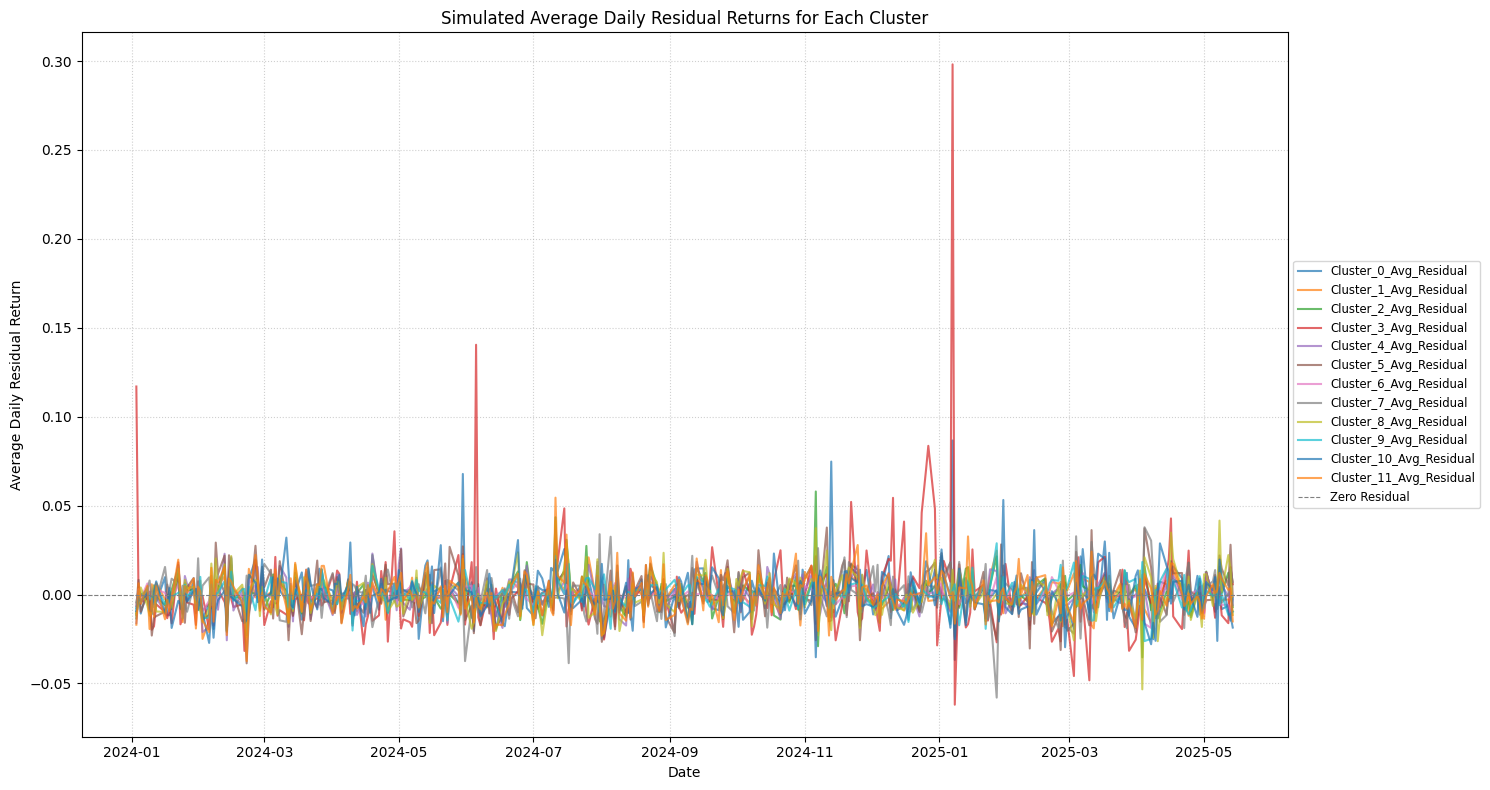

In [17]:
plt.figure(figsize=(15, 8))
for col in cluster_daily_avg_residuals.columns:
    plt.plot(cluster_daily_avg_residuals.index, cluster_daily_avg_residuals[col], label=col, alpha=0.7)

plt.title('Simulated Average Daily Residual Returns for Each Cluster')
plt.xlabel('Date')
plt.ylabel('Average Daily Residual Return')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8, label='Zero Residual')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

In [18]:
merged_tsne[merged_tsne['clusters'] == 7]

,Symbol,PC1,PC2,clusters,Sector,Name
27,AMAT,12.584400,44.805664,7,Technology,Applied Materials Inc. Common Stock
29,AMD,10.230922,43.521446,7,Technology,Advanced Micro Devices Inc. Common Stock
35,AMZN,9.332947,43.218430,7,Consumer Discretionary,Amazon.com Inc. Common Stock
37,ANSS,0.271818,43.907356,7,Technology,ANSYS Inc. Common Stock
40,APP,1.692454,44.021107,7,Technology,Applovin Corporation Class A Common Stock
52,AVGO,12.417809,46.210743,7,Technology,Broadcom Inc. Common Stock
77,CDNS,10.790272,45.187557,7,Technology,Cadence Design Systems Inc. Common Stock
81,CEG,11.119572,42.791389,7,Utilities,Constellation Energy Corporation Common Stock
107,CRWD,8.883219,44.677380,7,Technology,CrowdStrike Holdings Inc. Class A Common Stock
120,DDOG,12.008460,38.324921,7,Technology,Datadog Inc. Class A Common Stock


In [19]:
# Validating our thesis using Silhouette Score and Davies-Bouldin Index or Calinski-Harabasz Index
# Find the best cluster numbers by finding the optimal metrics

In [20]:
pc_scores = df_tsne.get(['PC1', 'PC2', 'Symbol']).set_index('Symbol')
sil_score = silhouette_score(pc_scores, tsne_clusters_aligned['cluster_label'])
dbi_score = davies_bouldin_score(pc_scores, tsne_clusters_aligned['cluster_label'])
chi_score = calinski_harabasz_score(pc_scores, tsne_clusters_aligned['cluster_label'])
print(sil_score, dbi_score, chi_score)

0.48648927 0.7084278058901939 925.7969


In [21]:
# run a for loop to find out the ideal number of clusters from 1 - 15
num_cluster = []
sil = []
dbi = []
chi = []

for i in range(2, 20):
    n_cluster = i
    print(f'Current cluster {i:}')
    pca_model = PCA(n_components=n_pca_component)
    pca_output = pca_model.fit_transform(resid_corr.values)
    tsne = TSNE(n_components=n_tsne_component, perplexity=15, init='random', random_state=42)
    embedding = tsne.fit_transform(pca_output)
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding)
    df_tsne = pd.DataFrame({
    'Symbol': ticker,
    'PC1': embedding[:,0],
    'PC2': embedding[:,1],
    'clusters': cluster_labels
    })
    pc_scores = df_tsne.get(['PC1', 'PC2', 'Symbol']).set_index('Symbol')
    corr_cluster = df_tsne['clusters']
    sil_score = silhouette_score(pc_scores, corr_cluster)
    dbi_score = davies_bouldin_score(pc_scores, corr_cluster)
    chi_score = calinski_harabasz_score(pc_scores, corr_cluster)
    print(sil_score, dbi_score, chi_score)
    num_cluster.append(i)
    dbi.append(dbi_score)
    chi.append(chi_score)
    sil.append(sil_score)

test_results = pd.DataFrame({
    'num_cluster': num_cluster,
    'sil': sil,
    'dbi': dbi,
    'chi': chi
    })
test_results
    

Current cluster 2
0.4638235 0.8431745733849295 594.25854
Current cluster 3
0.406096 0.8809236874011077 521.7142
Current cluster 4
0.41146496 0.8361856453053014 606.2732
Current cluster 5
0.44462895 0.7920825190678571 655.6492
Current cluster 6
0.43698207 0.7295468115166073 642.4374
Current cluster 7
0.45020235 0.7642580507568634 716.3651
Current cluster 8
0.4601337 0.7510108615110024 743.9373
Current cluster 9
0.48274487 0.6861505562792369 843.4175
Current cluster 10
0.4701845 0.7045395682986266 843.81335
Current cluster 11
0.4820326 0.7294125630348798 891.9749
Current cluster 12
0.48648927 0.7084278058901939 925.7969
Current cluster 13
0.47026023 0.7074640627062384 906.7614
Current cluster 14
0.4617947 0.7166160020934677 904.9924
Current cluster 15
0.44797114 0.7848379051385467 881.3375
Current cluster 16
0.4549746 0.7180851551923719 892.2375
Current cluster 17
0.45482177 0.7014071152138605 885.8347
Current cluster 18
0.45629406 0.6924321257325942 919.51263
Current cluster 19
0.455392

,num_cluster,sil,dbi,chi
0,2,0.463823,0.843175,594.258545
1,3,0.406096,0.880924,521.714172
2,4,0.411465,0.836186,606.273193
3,5,0.444629,0.792083,655.649170
4,6,0.436982,0.729547,642.437378
5,7,0.450202,0.764258,716.365112
6,8,0.460134,0.751011,743.937317
7,9,0.482745,0.686151,843.417480
8,10,0.470185,0.704540,843.813354
9,11,0.482033,0.729413,891.974915


In [22]:
resid_corr

,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
AAL,1.000000,0.045487,0.013940,0.062087,0.166405,0.018780,0.112186,-0.015802,0.123420,-0.038666,...,-0.015179,-0.021215,0.030480,0.231893,0.111321,-0.093232,0.034995,0.206322,0.033978,-0.027073
AAON,0.045487,1.000000,-0.244485,0.006797,-0.100677,0.032723,0.121121,-0.064526,-0.042473,-0.002442,...,0.004188,0.018463,0.014137,0.128257,0.110078,0.001087,0.012347,0.072648,0.034495,0.071909
AAPL,0.013940,-0.244485,1.000000,0.022736,0.032831,0.009754,0.022072,-0.025251,0.022508,-0.025851,...,-0.020584,-0.009895,-0.016633,-0.035816,0.020581,0.079602,-0.017742,-0.110754,0.007773,0.002507
ABAT,0.062087,0.006797,0.022736,1.000000,0.026815,0.017245,-0.000058,-0.005761,0.006238,0.100489,...,-0.055443,-0.002327,0.016923,0.018469,0.041217,-0.000568,0.021040,-0.000368,0.097028,0.008665
ABNB,0.166405,-0.100677,0.032831,0.026815,1.000000,-0.030687,0.032206,0.068934,0.120943,0.024653,...,0.230475,-0.074382,0.092531,0.137449,-0.019965,0.051326,0.104024,0.036202,0.112238,-0.008373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEO,-0.093232,0.001087,0.079602,-0.000568,0.051326,0.000623,-0.008191,0.052408,0.087195,0.053508,...,0.074813,-0.019882,0.054418,0.010211,-0.028127,1.000000,0.043804,0.065110,0.001231,-0.009860
ZG,0.034995,0.012347,-0.017742,0.021040,0.104024,-0.063113,-0.023237,0.071467,-0.058643,0.162917,...,-0.016456,0.050418,0.994947,0.030787,0.131158,0.043804,1.000000,-0.016126,0.086628,0.050909
ZION,0.206322,0.072648,-0.110754,-0.000368,0.036202,0.201502,0.249320,-0.072213,0.061608,0.052685,...,-0.071120,0.188690,-0.010364,0.299802,0.265550,0.065110,-0.016126,1.000000,0.103131,0.085399
ZM,0.033978,0.034495,0.007773,0.097028,0.112238,0.072688,0.072347,0.096368,0.000775,0.082414,...,-0.004736,0.047405,0.082223,0.028048,0.214495,0.001231,0.086628,0.103131,1.000000,0.265072


In [23]:
# bootstrap the sample to see if my cluster would change using a different sample size
optimal_n_pca_components = 6
optimal_tsne_output_dim = 2 
optimal_perplexity = 30            
optimal_n_clusters = 12


def run_clustering_pipeline(data_input, n_pca, tsne_dim, perp, n_clusters, random_seed_val):
    # Ensure data_input is a NumPy array for consistency
    data_input_arr = data_input.values if isinstance(data_input, pd.DataFrame) else data_input

    # PCA
    pca_model = PCA(n_components=n_pca, random_state=random_seed_val)
    pca_output = pca_model.fit_transform(data_input_arr)

    # t-SNE
    # Note: init='pca' is often more stable for t-SNE when using PCA output
    # Also, ensure learning_rate='auto' if sklearn version >= 1.0
    tsne_model = TSNE(n_components=tsne_dim, perplexity=perp, init='pca',
                      random_state=random_seed_val, learning_rate='auto', n_jobs=-1)
    embedding = tsne_model.fit_transform(pca_output)

    # KMeans
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=random_seed_val, n_init=10)
    cluster_labels = kmeans_model.fit_predict(embedding)

    return cluster_labels, embedding

In [78]:
from tqdm.notebook import tqdm
# define our parameter range (DONT RUN THIS CODE AGAIN TOOK 20 MIN)
# pca_n_components_range = list(range(2, 10, 1)) # Example range based on prior PCA analysis
# tsne_output_n_components_range = [2] # Usually 2 or 3 for t-SNE output
# perplexity_range = list(range(5, 50, 5)) # Example common perplexity values
# kmeans_n_clusters_range = list(range(8, 20, 1)) # Your range for optimal clusters
# bootstrap_time = list(range(10))
pca_n_components_range = list(range(2, 3, 1)) # Example range based on prior PCA analysis
tsne_output_n_components_range = [2] # Usually 2 or 3 for t-SNE output
perplexity_range = list(range(10, 16, 1)) # Example common perplexity values
kmeans_n_clusters_range = list(range(8, 16, 1)) # Your range for optimal clusters
bootstrap_time = list(range(10))

original_stock_indices = resid_corr.index # This is crucial for tracking samples
original_data_values = resid_corr.values

original_cluster_labels, original_embedding = run_clustering_pipeline(
    data_input=original_data_values,
    n_pca=optimal_n_pca_components,
    tsne_dim=optimal_tsne_output_dim,
    perp=optimal_perplexity,
    n_clusters=optimal_n_clusters,
    random_seed_val=42 
)

results_list = [] # To store results from each combination
for i in tqdm(bootstrap_time):

    bootstrap_indices_sampled = np.random.choice(
        original_stock_indices, # Choose from original indices
        size=len(original_stock_indices), # Same size as original
        replace=True # With replacement
    )

    bootstrap_data_values = resid_corr.loc[bootstrap_indices_sampled].values


    for pca_comp in tqdm(pca_n_components_range):
        pca_model = PCA(n_components=pca_comp, random_state=42)
        pca_output = pca_model.fit_transform(bootstrap_data_values)
        for tsne_dim in (tsne_output_n_components_range):
            for perp in (perplexity_range):
                try:
                    tsne_model = TSNE(n_components=tsne_dim, perplexity=perp, init='pca', random_state=42, learning_rate='auto', n_jobs=-1)
                    embedding = tsne_model.fit_transform(pca_output)
                except Exception as e:
                    print(f"    t-SNE failed for perp={perp}, dim={tsne_dim}: {e}. Skipping combination.")
                    continue # Skip to next iteration if t-SNE fails
                for k in (kmeans_n_clusters_range):

                    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
                    cluster_labels = kmeans_model.fit_predict(embedding)
                    sil = silhouette_score(embedding, cluster_labels)
                    dbi = davies_bouldin_score(embedding, cluster_labels)
                    chi = calinski_harabasz_score(embedding, cluster_labels)

                    results_list.append({
                        'n_pca': pca_comp,
                        'n_tsne_out_dim': tsne_dim,
                        'perplexity': perp,
                        'n_clusters': k,
                        'silhouette': sil,
                        'dbi': dbi,
                        'chi': chi,
                        'boot_samp_num': i,
                    })

results_df = pd.DataFrame(results_list)
results_df

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,n_pca,n_tsne_out_dim,perplexity,n_clusters,silhouette,dbi,chi,boot_samp_num
0,2,2,10,8,0.463809,0.712474,686.645813,0
1,2,2,10,9,0.466233,0.744570,710.084473,0
2,2,2,10,10,0.456707,0.744065,706.440430,0
3,2,2,10,11,0.476260,0.713027,698.222290,0
4,2,2,10,12,0.495993,0.664707,710.115173,0
...,...,...,...,...,...,...,...,...
475,2,2,15,11,0.463585,0.754855,725.079163,9
476,2,2,15,12,0.472193,0.736525,768.720154,9
477,2,2,15,13,0.491187,0.695426,812.045288,9
478,2,2,15,14,0.504890,0.673308,856.991577,9


In [79]:
results_df.groupby(['n_pca', 'n_tsne_out_dim', 'perplexity', 'n_clusters']).agg(['mean','std']).sort_values(by=[('silhouette', 'mean')], ascending=False)

silhouette                 dbi  \
                                                 mean       std      mean   
n_pca n_tsne_out_dim perplexity n_clusters                                  
2     2              14         15           0.500872  0.017118  0.677817   
                     12         14           0.496383  0.021867  0.684029   
                     15         14           0.495516  0.018909  0.682570   
                     13         14           0.495004  0.020625  0.675467   
                                15           0.494979  0.021029  0.678300   
                     15         15           0.493400  0.019737  0.683588   
                     14         14           0.492948  0.019527  0.690985   
                                13           0.492879  0.020439  0.677774   
                     11         15           0.491927  0.018954  0.676064   
                     13         13           0.491605  0.018758  0.685338   
                     12         13           0.491093  0.025582  0.689901   
                                15           0.490197  0.032054  0.685108   
                     15         13           0.489483  0.017837  0.689960   
                     10         15           0.488253  0.023576  0.688585   
                     12         12           0.488041  0.021430  0.681981   
                     13         12           0.487276  0.024100  0.688285   
                     14         12           0.484534  0.021417  0.692821   
                     11         14           0.484217  0.014613  0.686702   
                     10         14           0.483333  0.018594  0.703134   
                     12         11           0.482963  0.019940  0.691496   
                     15         12           0.482750  0.021506  0.698228   
                                11           0.481819  0.020136  0.699550   
                     10         13           0.481149  0.023002  0.697059   
                     14         11           0.480659  0.021156  0.703122   
                     10         12           0.479501  0.017913  0.692454   
                     13         11           0.478892  0.023453  0.693716   
                     11         13           0.476423  0.022883  0.706749   
                     14         10           0.476116  0.020589  0.708636   
                     11         12           0.475918  0.023096  0.692919   
                     10         11           0.473093  0.024432  0.698713   
                     12         10           0.471963  0.023015  0.709309   
                     15         10           0.471834  0.025055  0.712350   
                     11         11           0.470760  0.022971  0.703902   
                     15         9            0.470203  0.023104  0.704295   
                     13         10           0.469974  0.021640  0.716198   
                     14         9            0.464567  0.025613  0.719720   
                     13         9            0.464101  0.026851  0.717055   
                     11         10           0.463744  0.023836  0.728752   
                     12         9            0.463320  0.022529  0.720897   
                     10         10           0.462538  0.026142  0.714081   
                     15         8            0.460300  0.023516  0.726039   
                     14         8            0.456114  0.027313  0.727923   
                     11         9            0.456092  0.022817  0.726378   
                     12         8            0.455624  0.020445  0.731153   
                     13         8            0.454733  0.024703  0.741697   
                     10         9            0.454061  0.023150  0.725851   
                     11         8            0.445772  0.027177  0.738158   
                     10         8            0.443705  0.024131  0.742753   

                                                             chi             \
                                    

In [81]:
results_scores = results_df.groupby(['n_pca', 'n_tsne_out_dim', 'perplexity', 'n_clusters']).agg(['mean','std'])
results_scores

silhouette                 dbi  \
                                                 mean       std      mean   
n_pca n_tsne_out_dim perplexity n_clusters                                  
2     2              10         8            0.443705  0.024131  0.742753   
                                9            0.454061  0.023150  0.725851   
                                10           0.462538  0.026142  0.714081   
                                11           0.473093  0.024432  0.698713   
                                12           0.479501  0.017913  0.692454   
                                13           0.481149  0.023002  0.697059   
                                14           0.483333  0.018594  0.703134   
                                15           0.488253  0.023576  0.688585   
                     11         8            0.445772  0.027177  0.738158   
                                9            0.456092  0.022817  0.726378   
                                10           0.463744  0.023836  0.728752   
                                11           0.470760  0.022971  0.703902   
                                12           0.475918  0.023096  0.692919   
                                13           0.476423  0.022883  0.706749   
                                14           0.484217  0.014613  0.686702   
                                15           0.491927  0.018954  0.676064   
                     12         8            0.455624  0.020445  0.731153   
                                9            0.463320  0.022529  0.720897   
                                10           0.471963  0.023015  0.709309   
                                11           0.482963  0.019940  0.691496   
                                12           0.488041  0.021430  0.681981   
                                13           0.491093  0.025582  0.689901   
                                14           0.496383  0.021867  0.684029   
                                15           0.490197  0.032054  0.685108   
                     13         8            0.454733  0.024703  0.741697   
                                9            0.464101  0.026851  0.717055   
                                10           0.469974  0.021640  0.716198   
                                11           0.478892  0.023453  0.693716   
                                12           0.487276  0.024100  0.688285   
                                13           0.491605  0.018758  0.685338   
                                14           0.495004  0.020625  0.675467   
                                15           0.494979  0.021029  0.678300   
                     14         8            0.456114  0.027313  0.727923   
                                9            0.464567  0.025613  0.719720   
                                10           0.476116  0.020589  0.708636   
                                11           0.480659  0.021156  0.703122   
                                12           0.484534  0.021417  0.692821   
                                13           0.492879  0.020439  0.677774   
                                14           0.492948  0.019527  0.690985   
                                15           0.500872  0.017118  0.677817   
                     15         8            0.460300  0.023516  0.726039   
                                9            0.470203  0.023104  0.704295   
                                10           0.471834  0.025055  0.712350   
                                11           0.481819  0.020136  0.699550   
                                12           0.482750  0.021506  0.698228   
                                13           0.489483  0.017837  0.689960   
                                14           0.495516  0.018909  0.682570   
                                15           0.493400  0.019737  0.683588   

                                                             chi             \
                                    

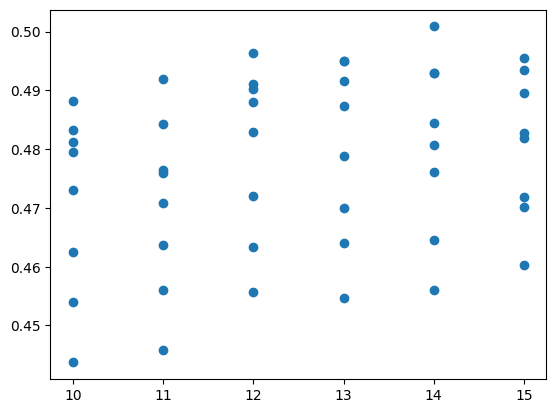

In [82]:
plt.scatter(results_scores.reset_index()['perplexity'], results_scores.reset_index()[('silhouette', 'mean')])

In [27]:
results_scores.sort_values(by=[('dbi', 'mean')], ascending=True).head(5)

silhouette                 dbi  \
                                                 mean       std      mean   
n_pca n_tsne_out_dim perplexity n_clusters                                  
2     2              10         300          0.470620  0.016768  0.310988   
                                290          0.473159  0.016888  0.335772   
                                280          0.478582  0.017019  0.352046   
                                270          0.483053  0.017285  0.377992   
                                260          0.486876  0.015672  0.398291   

                                                              chi              \
                                                 std         mean         std   
n_pca n_tsne_out_dim perplexity n_clusters                                      
2     2              10         300         0.018012  5782.505371  327.355621   
                                290         0.014520  5442.553223  286.922516   
                                280         0.016683  5205.606445  281.278839   
                                270         0.018001  5018.938477  323.618469   
                                260         0.017374  4794.989258  310.432526   

                                           boot_samp_num           
                                                    mean      std  
n_pca n_tsne_out_dim perplexity n_clusters                         
2     2              10         300                  4.5  3.02765  
                                290                  4.5  3.02765  
                                280                  4.5  3.02765  
                                270                  4.5  3.02765  
                                260                  4.5  3.02765

In [28]:
results_scores.sort_values(by=[('chi', 'mean')], ascending=False).head(5)

silhouette                 dbi  \
                                                 mean       std      mean   
n_pca n_tsne_out_dim perplexity n_clusters                                  
2     2              10         300          0.470620  0.016768  0.310988   
                                290          0.473159  0.016888  0.335772   
                                280          0.478582  0.017019  0.352046   
                                270          0.483053  0.017285  0.377992   
                                260          0.486876  0.015672  0.398291   

                                                              chi              \
                                                 std         mean         std   
n_pca n_tsne_out_dim perplexity n_clusters                                      
2     2              10         300         0.018012  5782.505371  327.355621   
                                290         0.014520  5442.553223  286.922516   
                                280         0.016683  5205.606445  281.278839   
                                270         0.018001  5018.938477  323.618469   
                                260         0.017374  4794.989258  310.432526   

                                           boot_samp_num           
                                                    mean      std  
n_pca n_tsne_out_dim perplexity n_clusters                         
2     2              10         300                  4.5  3.02765  
                                290                  4.5  3.02765  
                                280                  4.5  3.02765  
                                270                  4.5  3.02765  
                                260                  4.5  3.02765

In [29]:
results_scores

silhouette                 dbi  \
                                                 mean       std      mean   
n_pca n_tsne_out_dim perplexity n_clusters                                  
2     2              10         10           0.448394  0.013900  0.737754   
                                20           0.509024  0.014151  0.645898   
                                30           0.545536  0.020897  0.593016   
                                40           0.565385  0.014229  0.556791   
                                50           0.570204  0.013932  0.550138   
                                60           0.565943  0.013713  0.551299   
                                70           0.561644  0.010330  0.552217   
                                80           0.555220  0.010005  0.553937   
                                90           0.552229  0.010406  0.555166   
                                100          0.544330  0.013434  0.553806   
                                110          0.541780  0.013748  0.552232   
                                120          0.536017  0.015434  0.548225   
                                130          0.533338  0.014717  0.554894   
                                140          0.527893  0.011292  0.549531   
                                150          0.524134  0.014970  0.543533   
                                160          0.517324  0.009209  0.545593   
                                170          0.518330  0.013239  0.524955   
                                180          0.511776  0.011506  0.522044   
                                190          0.513189  0.018063  0.507622   
                                200          0.507393  0.016987  0.493997   
                                210          0.511297  0.019996  0.478051   
                                220          0.503399  0.014212  0.471374   
                                230          0.500438  0.015769  0.452055   
                                240          0.493328  0.018407  0.436027   
                                250          0.489611  0.018158  0.418560   
                                260          0.486876  0.015672  0.398291   
                                270          0.483053  0.017285  0.377992   
                                280          0.478582  0.017019  0.352046   
                                290          0.473159  0.016888  0.335772   
                                300          0.470620  0.016768  0.310988   

                                                              chi              \
                                                 std         mean         std   
n_pca n_tsne_out_dim perplexity n_clusters                                      
2     2              10         10          0.029307   644.793091   48.731052   
                                20          0.027154   879.264465   54.314816   
                                30          0.031209  1184.715088  124.941986   
                                40          0.020623  1505.243896  162.786728   
                                50          0.027091  1794.022827  209.760803   
                                60          0.020303  2040.123779  236.763519   
                                70          0.013928  2273.326904  223.907043   
                                80          0.013363  2478.807373  247.263809   
                                90          0.014518  2650.191650  263.048950   
                                100         0.020512  2833.873535  248.674301   
                                110         0.025308  2964.459717  251.392654   
                                120         0.014422  3148.813965  223.849411   
                                130         0.013382  3290.031250  252.302948   
                                140         0.018395  3446.187988  240.778015   
                                150         0.023814  3536.465576  251.811646   
                                160        

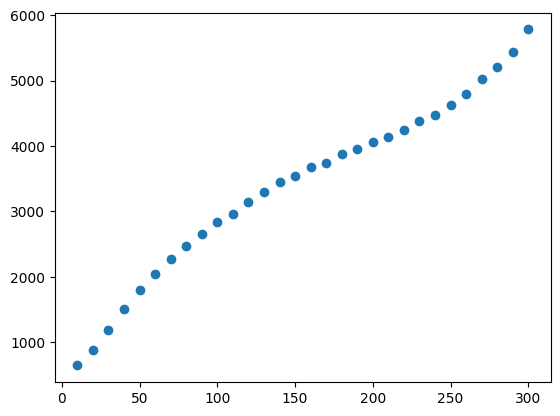

In [30]:
plt.scatter(results_scores.reset_index()['n_clusters'], results_scores[('chi', 'mean')])

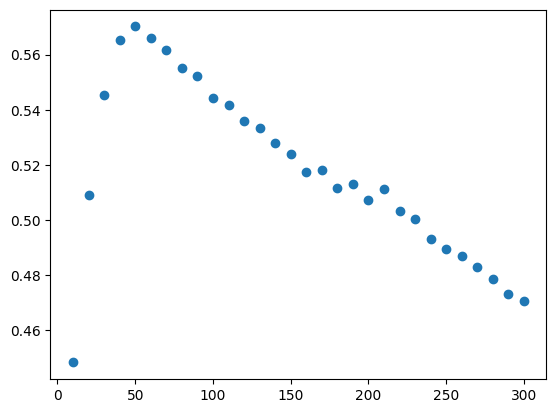

In [31]:
plt.scatter(results_scores.reset_index()['n_clusters'], results_scores[('silhouette', 'mean')])

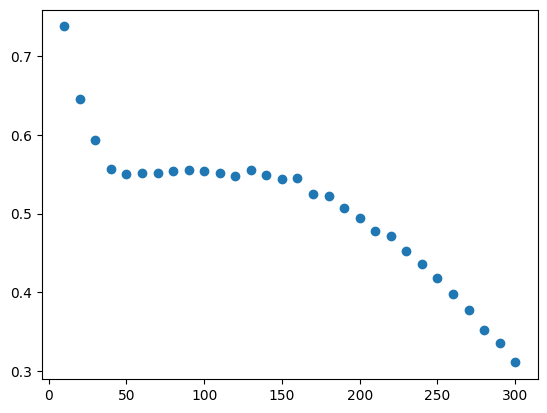

In [32]:
plt.scatter(results_scores.reset_index()['n_clusters'], results_scores[('dbi', 'mean')])

In [33]:
results_df.groupby(['boot_samp_num', 'n_pca', 'n_tsne_out_dim', 'perplexity', 'n_clusters']).mean().sort_values(by='dbi', ascending=True).head(5)

,,,,,silhouette,dbi,chi
boot_samp_num,n_pca,n_tsne_out_dim,perplexity,n_clusters,,,
0,2,2,10,300,0.485684,0.287765,5779.071289
6,2,2,10,300,0.488335,0.292620,5728.341797
3,2,2,10,300,0.475603,0.294367,5730.354492
2,2,2,10,300,0.481967,0.302160,5660.944336
9,2,2,10,300,0.477949,0.310314,5349.887207


In [34]:
results_df.groupby(['boot_samp_num', 'n_pca', 'n_tsne_out_dim', 'perplexity', 'n_clusters']).mean().sort_values(by='chi', ascending=False).head(5)

,,,,,silhouette,dbi,chi
boot_samp_num,n_pca,n_tsne_out_dim,perplexity,n_clusters,,,
1,2,2,10,300,0.467231,0.327067,6223.950195
4,2,2,10,300,0.432431,0.346666,6100.860352
5,2,2,10,300,0.475939,0.310333,6048.783691
7,2,2,10,300,0.466882,0.322345,6004.016602
1,2,2,10,290,0.472123,0.345096,5875.545898


In [35]:
# Find the best combination based on Silhouette Score
best_silhouette = results_df.sort_values(by='silhouette', ascending=False).head(5)
print("\nTop 5 combinations by Silhouette Score:")
print(best_silhouette)

# Find the best combination based on Davies-Bouldin Index
best_dbi = results_df.sort_values(by='dbi', ascending=True).head(5)
print("\nTop 5 combinations by Davies-Bouldin Index:")
print(best_dbi)


Top 5 combinations by Silhouette Score:
     n_pca  n_tsne_out_dim  perplexity  n_clusters  silhouette       dbi  \
124      2               2          10          50    0.588650  0.527119   
214      2               2          10          50    0.585011  0.533006   
244      2               2          10          50    0.584656  0.505445   
123      2               2          10          40    0.583939  0.514385   
153      2               2          10          40    0.583373  0.555794   

             chi  boot_samp_num  
124  2200.551025              4  
214  1835.094116              7  
244  1714.733765              8  
123  1750.260376              4  
153  1731.595581              5  

Top 5 combinations by Davies-Bouldin Index:
     n_pca  n_tsne_out_dim  perplexity  n_clusters  silhouette       dbi  \
29       2               2          10         300    0.485684  0.287765   
209      2               2          10         300    0.488335  0.292620   
119      2               

In [36]:
# Find the best combination based on Calinski-Harabasz Index
best_chi = results_df.sort_values(by='chi', ascending=False).head(5)
print("\nTop 5 combinations by Calinski-Harabasz Index:")
print(best_chi)


Top 5 combinations by Calinski-Harabasz Index:
     n_pca  n_tsne_out_dim  perplexity  n_clusters  silhouette       dbi  \
59       2               2          10         300    0.467231  0.327067   
149      2               2          10         300    0.432431  0.346666   
179      2               2          10         300    0.475939  0.310333   
239      2               2          10         300    0.466882  0.322345   
58       2               2          10         290    0.472123  0.345096   

             chi  boot_samp_num  
59   6223.950195              1  
149  6100.860352              4  
179  6048.783691              5  
239  6004.016602              7  
58   5875.545898              1  


In [37]:
original_stock_indices = resid_corr.index # This is crucial for tracking samples
original_data_values = resid_corr.values

original_cluster_labels, original_embedding = run_clustering_pipeline(
    data_input=original_data_values,
    n_pca=optimal_n_pca_components,
    tsne_dim=optimal_tsne_output_dim,
    perp=optimal_perplexity,
    n_clusters=optimal_n_clusters,
    random_seed_val=42 
)

original_labels_series = pd.Series(original_cluster_labels, index=original_stock_indices)


num_bootstrap_iterations = 100 # A common number, increase for more robust results
bootstrap_ari_scores = []

for i in range(num_bootstrap_iterations):
    # Generate bootstrap sample indices (sampling with replacement)
    # We sample the *indices* of the original data to preserve identity
    bootstrap_indices_sampled = np.random.choice(
        original_stock_indices, # Choose from original indices
        size=len(original_stock_indices), # Same size as original
        replace=True # With replacement
    )

    # Create the bootstrap data (use .loc if original is DataFrame, direct indexing if NumPy array)
    # This creates a new matrix with some rows duplicated and some omitted.
    bootstrap_data_values = resid_corr.loc[bootstrap_indices_sampled].values
    # Note: The order of rows in bootstrap_data_values corresponds to bootstrap_indices_sampled

    # Run the clustering pipeline on the bootstrap sample
    # IMPORTANT: Use a consistent random_state for reproducibility within each bootstrap run,
    # or vary it if you want to test sensitivity to algorithmic randomness too.
    # Keeping it fixed (e.g., i for each iter) is usually good for stability testing.
    bootstrap_labels, _ = run_clustering_pipeline(
        data_input=bootstrap_data_values,
        n_pca=optimal_n_pca_components,
        tsne_dim=optimal_tsne_output_dim,
        perp=optimal_perplexity,
        n_clusters=optimal_n_clusters,
        random_seed_val=i # Vary random state per iteration
    )
    # Store bootstrap labels with their corresponding indices (from bootstrap_indices_sampled)
    bootstrap_labels_series = pd.Series(bootstrap_labels, index=bootstrap_indices_sampled)

    # --- Align samples for comparison ---
    # Find stocks that are present in both the original and this bootstrap sample
    # Note: A stock can appear multiple times in bootstrap_labels_series due to replacement.
    # We need to ensure we compare based on unique original identities.

    # Get unique original stock IDs that appear in this bootstrap sample
    unique_original_stocks_in_bootstrap = bootstrap_labels_series.index.unique()

    # Filter for common stocks between original and this bootstrap sample
    common_stocks = original_labels_series.index.intersection(unique_original_stocks_in_bootstrap)

    if len(common_stocks) > 1: # Need at least 2 common samples for ARI
        # Get the reference labels for only these common stocks
        ref_labels_for_ari = original_labels_series.loc[common_stocks]

        # Get the bootstrap labels for these common stocks.
        # If a stock was duplicated in bootstrap_indices_sampled, its label will appear multiple times.
        # We need to take a single label for each unique common stock from the bootstrap result.
        # A common way is to take the mode (most frequent label) if a stock appears multiple times,
        # or just the first one if we assume consistency. For simplicity, let's align by index
        # and ensure unique indices for comparison.

        # Create a Series of labels for common stocks from the bootstrap result.
        # This requires careful re-indexing if bootstrap_labels_series has duplicates.
        # A robust way is to re-run the pipeline on *just the unique common stocks*
        # if cluster labels must be exactly from one run, or average.
        # More commonly for ARI, we just use the first instance's label if duplicates exist in bootstrap.
        # Simpler approach: Map the labels back to original common_stocks order

        # To handle duplicates in bootstrap_labels_series (from `np.random.choice(..., replace=True)`):
        # For ARI, we need a single label for each unique sample.
        # If a stock appears multiple times in the bootstrap sample, it will have multiple labels.
        # The most straightforward way is to take the *first* label assigned to it if it was duplicated,
        # OR consider only unique stocks that appeared in the bootstrap sample.

        # Let's align by getting the unique indices of the bootstrap sample, then intersect with original.
        # And take the first label for each unique stock in the bootstrap result.
        aligned_bootstrap_labels = bootstrap_labels_series.groupby(level=0).first().loc[common_stocks] # Get first label for each unique stock

        # Calculate ARI
        ari_score = adjusted_rand_score(ref_labels_for_ari, aligned_bootstrap_labels)
        bootstrap_ari_scores.append(ari_score)
    else:
        print(f"  Iteration {i+1}: Not enough common samples ({len(common_stocks)}) for ARI calculation. Skipping.")

    if (i + 1) % 10 == 0:
        print(f"  Iteration {i+1} complete. Current mean ARI: {np.mean(bootstrap_ari_scores):.4f}")

print("\nBootstrap analysis complete.")

# --- 4. Analyze Results ---
if bootstrap_ari_scores:
    mean_ari = np.mean(bootstrap_ari_scores)
    std_ari = np.std(bootstrap_ari_scores)
    min_ari = np.min(bootstrap_ari_scores)
    max_ari = np.max(bootstrap_ari_scores)

    print(f"\n--- Bootstrap Clustering Stability Results (n={num_bootstrap_iterations} iterations) ---")
    print(f"Mean Adjusted Rand Index (ARI): {mean_ari:.4f}")
    print(f"Standard Deviation of ARI:      {std_ari:.4f}")
    print(f"Minimum ARI:                    {min_ari:.4f}")
    print(f"Maximum ARI:                    {max_ari:.4f}")

    plt.figure(figsize=(8, 5))
    plt.hist(bootstrap_ari_scores, bins=15, edgecolor='black', alpha=0.7)
    plt.axvline(mean_ari, color='red', linestyle='dashed', linewidth=1, label=f'Mean ARI: {mean_ari:.4f}')
    plt.title('Distribution of Adjusted Rand Index Scores from Bootstrapping')
    plt.xlabel('Adjusted Rand Index (ARI)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Interpretation:
    if mean_ari > 0.8:
        print("Interpretation: Very strong clustering stability. Clusters are highly robust to sampling variations.")
    elif mean_ari > 0.6:
        print("Interpretation: Good clustering stability. Clusters are reasonably robust.")
    elif mean_ari > 0.4:
        print("Interpretation: Moderate clustering stability. Clusters show some sensitivity to sampling.")
    else:
        print("Interpretation: Low clustering stability. Clusters are highly dependent on the specific sample.")

else:
    print("No ARI scores were calculated. Check common sample filtering.")


  Iteration 10 complete. Current mean ARI: 0.4676
  Iteration 20 complete. Current mean ARI: 0.4779
  Iteration 30 complete. Current mean ARI: 0.4664


KeyboardInterrupt: 

In [38]:
residuals

,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-03,-0.022897,0.000043,0.002564,-0.026922,0.003487,0.012460,-0.000332,-0.004594,-0.010152,-0.067865,...,0.041304,-0.014400,-0.024295,-0.044985,-0.008836,0.005463,-0.028755,-0.038437,-0.022029,0.002227
2024-01-04,0.017157,0.012895,-0.008255,0.011023,0.007439,-0.031574,-0.014615,-0.003275,-0.009234,-0.024929,...,0.042179,-0.009666,-0.014688,0.007464,0.002507,0.000955,-0.018066,0.019600,-0.001287,0.005805
2024-01-05,0.037044,-0.020607,-0.005988,-0.024692,0.015015,0.044464,0.004102,-0.004650,-0.000127,-0.016518,...,0.003216,-0.009340,-0.010841,-0.003468,-0.005979,-0.000271,-0.008640,0.030920,-0.000805,-0.004974
2024-01-08,0.050816,-0.003150,0.007184,-0.025832,0.011715,-0.032475,0.001332,0.015422,-0.010183,0.001266,...,-0.022613,0.006452,0.017076,0.012067,0.007617,-0.004325,0.021375,-0.006248,0.009283,0.018583
2024-01-09,-0.010439,-0.012306,-0.000202,-0.003755,-0.001363,-0.011415,0.001705,0.012763,0.006933,0.009199,...,0.037352,-0.010475,-0.002126,-0.015114,-0.013858,0.001058,-0.002202,-0.009281,-0.000084,0.039866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,0.036341,0.030163,-0.000513,0.045436,0.019321,-0.068335,0.148548,-0.006917,0.005273,-0.008212,...,0.067418,-0.014756,-0.007698,0.022999,0.018965,-0.032172,-0.003424,0.023332,0.015417,-0.010131
2025-05-09,0.009326,0.008502,0.006391,-0.004654,0.006674,0.109128,0.066018,0.000402,0.024853,-0.162722,...,0.112443,0.003528,0.001395,0.006572,-0.041920,0.044499,0.001398,-0.004564,0.013648,0.000917
2025-05-12,0.000156,-0.002454,0.023617,-0.087636,0.013161,0.061128,0.004298,0.001445,0.021388,-0.028678,...,-0.049055,-0.022907,0.003530,0.075818,0.084065,-0.072509,0.004181,0.023205,-0.010913,-0.012458


In [39]:
residuals

,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-03,-0.022897,0.000043,0.002564,-0.026922,0.003487,0.012460,-0.000332,-0.004594,-0.010152,-0.067865,...,0.041304,-0.014400,-0.024295,-0.044985,-0.008836,0.005463,-0.028755,-0.038437,-0.022029,0.002227
2024-01-04,0.017157,0.012895,-0.008255,0.011023,0.007439,-0.031574,-0.014615,-0.003275,-0.009234,-0.024929,...,0.042179,-0.009666,-0.014688,0.007464,0.002507,0.000955,-0.018066,0.019600,-0.001287,0.005805
2024-01-05,0.037044,-0.020607,-0.005988,-0.024692,0.015015,0.044464,0.004102,-0.004650,-0.000127,-0.016518,...,0.003216,-0.009340,-0.010841,-0.003468,-0.005979,-0.000271,-0.008640,0.030920,-0.000805,-0.004974
2024-01-08,0.050816,-0.003150,0.007184,-0.025832,0.011715,-0.032475,0.001332,0.015422,-0.010183,0.001266,...,-0.022613,0.006452,0.017076,0.012067,0.007617,-0.004325,0.021375,-0.006248,0.009283,0.018583
2024-01-09,-0.010439,-0.012306,-0.000202,-0.003755,-0.001363,-0.011415,0.001705,0.012763,0.006933,0.009199,...,0.037352,-0.010475,-0.002126,-0.015114,-0.013858,0.001058,-0.002202,-0.009281,-0.000084,0.039866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,0.036341,0.030163,-0.000513,0.045436,0.019321,-0.068335,0.148548,-0.006917,0.005273,-0.008212,...,0.067418,-0.014756,-0.007698,0.022999,0.018965,-0.032172,-0.003424,0.023332,0.015417,-0.010131
2025-05-09,0.009326,0.008502,0.006391,-0.004654,0.006674,0.109128,0.066018,0.000402,0.024853,-0.162722,...,0.112443,0.003528,0.001395,0.006572,-0.041920,0.044499,0.001398,-0.004564,0.013648,0.000917
2025-05-12,0.000156,-0.002454,0.023617,-0.087636,0.013161,0.061128,0.004298,0.001445,0.021388,-0.028678,...,-0.049055,-0.022907,0.003530,0.075818,0.084065,-0.072509,0.004181,0.023205,-0.010913,-0.012458


In [139]:
# --- Helper Function: The Clustering & Selection Pipeline ---
# This function remains mostly the same as in the previous code,
# encapsulating the steps that run at each rebalancing point.
def _get_long_short_stocks_for_window(
    current_residuals_window_data, # DataFrame of residuals for the lookback window (dates x stocks)
    optimal_n_pca, optimal_tsne_dim, optimal_perp, optimal_n_clusters,
    num_top_clusters, num_bottom_clusters, proportion_to_invest, random_seed_val # Changed parameters
):
    # Ensure data is sufficient for clustering.
    pca_input_data = current_residuals_window_data.T # (stocks x days)
    n_samples_pca = pca_input_data.shape[0] # Number of stocks
    n_features_pca = pca_input_data.shape[1] # Number of days in window

    if n_samples_pca < 2 or n_features_pca < 2:
        return [], [] # Not enough stocks or days for meaningful clustering

    # Adjust n_pca_components if window size is too small for PCA
    actual_n_pca = min(optimal_n_pca, n_features_pca -1)
    if actual_n_pca < 1: return [], []

    # Adjust perplexity if window size is too small for t-SNE
    actual_perp = min(optimal_perp, n_samples_pca - 1)
    if actual_perp < 2: actual_perp = 2 # Perplexity must be >= 2

    # Adjust n_clusters if number of stocks in window is too small for KMeans
    n_clusters_for_kmeans_window = min(optimal_n_clusters, n_samples_pca)
    if n_clusters_for_kmeans_window < 2: n_clusters_for_kmeans_window = 2
    
    # --- Clustering Pipeline ---
    try:
        # PCA
        pca_model = PCA(n_components=actual_n_pca, random_state=random_seed_val)
        pca_output = pca_model.fit_transform(pca_input_data)

        # t-SNE
        tsne_model = TSNE(n_components=optimal_tsne_dim, perplexity=actual_perp,
                          init='pca', random_state=random_seed_val, learning_rate='auto', n_jobs=-1)
        embedding = tsne_model.fit_transform(pca_output)

        # KMeans
        kmeans_model = KMeans(n_clusters=n_clusters_for_kmeans_window, random_state=random_seed_val, n_init=10)
        cluster_labels = kmeans_model.fit_predict(embedding)

        # Create stock_to_cluster_map for this window
        stock_to_cluster_map = pd.Series(cluster_labels, index=current_residuals_window_data.columns)
        stock_to_cluster_map.name = 'Cluster_Label'

        # --- Stock Selection within Clusters ---
        individual_stock_avg_residuals_window = current_residuals_window_data.mean()
        individual_stock_avg_residuals_window.name = 'Avg_Residual_Return'

        cluster_daily_avg_residuals_window_df = pd.DataFrame()
        for cl_label in sorted(stock_to_cluster_map.unique()):
            stocks_in_cl = stock_to_cluster_map[stock_to_cluster_map == cl_label].index.tolist()
            if stocks_in_cl:
                cluster_daily_avg_residuals_window_df[f'Cluster_{cl_label}_Avg_Residual'] = \
                    current_residuals_window_data[stocks_in_cl].mean(axis=1)
        
        if cluster_daily_avg_residuals_window_df.empty: return [], []
        
        overall_average_residuals_clusters_window = cluster_daily_avg_residuals_window_df.mean()

        # --- Adjusted Cluster Selection Logic ---
        # Ensure we don't try to pick more clusters than available
        available_clusters = len(overall_average_residuals_clusters_window)
        
        actual_num_top_clusters = min(num_top_clusters, available_clusters // 2)
        actual_num_bottom_clusters = min(num_bottom_clusters, available_clusters - actual_num_top_clusters) # Remaining for bottom

        if actual_num_top_clusters == 0 and actual_num_bottom_clusters == 0:
            return [], [] # No clusters to pick from

        sorted_clusters = overall_average_residuals_clusters_window.sort_values(ascending=False)
        
        # Select top clusters for longing
        top_filter = sorted_clusters[sorted_clusters.values > 0]
        print(top_filter)
        overperformer_cluster_ids = [int(name.split('_')[1]) for name in top_filter.head(actual_num_top_clusters).index.tolist()]
        
        # Select bottom clusters for shorting
        # Ensure we don't overlap with top clusters if available_clusters is small
        bot_filter = sorted_clusters[sorted_clusters.values < 0]
        print(bot_filter)
        bottom_clusters_candidates = bot_filter.tail(available_clusters - actual_num_top_clusters)
        underperformer_cluster_ids = [int(name.split('_')[1]) for name in bottom_clusters_candidates.head(actual_num_bottom_clusters).index.tolist()]


        final_long_stocks = []
        final_short_stocks = []

        stock_details_window = stock_to_cluster_map.to_frame().join(individual_stock_avg_residuals_window, how='inner')

        # Process Underperforming Clusters (for Short Positions)
        for cluster_id in underperformer_cluster_ids:
            stocks_in_cl = stock_details_window[stock_details_window['Cluster_Label'] == cluster_id]
            ranked_stocks = stocks_in_cl.sort_values(by='Avg_Residual_Return', ascending=False)
            num_to_select = int(len(ranked_stocks) * proportion_to_invest)
            if num_to_select == 0 and len(ranked_stocks) > 0: num_to_select = 1
            final_long_stocks.extend(ranked_stocks.head(num_to_select).index.tolist())

        # Process Overperforming Clusters (for Long Positions)
        for cluster_id in overperformer_cluster_ids:
            stocks_in_cl = stock_details_window[stock_details_window['Cluster_Label'] == cluster_id]
            ranked_stocks = stocks_in_cl.sort_values(by='Avg_Residual_Return', ascending=True)
            num_to_select = int(len(ranked_stocks) * proportion_to_invest)
            if num_to_select == 0 and len(ranked_stocks) > 0: num_to_select = 1
            final_short_stocks.extend(ranked_stocks.head(num_to_select).index.tolist())
            
        # Ensure selected stocks actually have data in the current window for the next period (for safety)
        available_stocks_next_period = current_residuals_window_data.columns.tolist() # Assuming all stocks in window are available
        final_long_stocks = [s for s in final_long_stocks if s in available_stocks_next_period]
        final_short_stocks = [s for s in final_short_stocks if s in available_stocks_next_period]

        return final_long_stocks, final_short_stocks

    except Exception as e:
        # print(f"  Warning: Clustering/Selection failed for window ({e}). Returning empty lists.")
        return [], [] # Return empty lists if any part of the pipeline fails

# --- Main Simulation Function ---
def simulate_rebalancing_portfolio(
    residuals: pd.DataFrame,
    stock_returns: pd.DataFrame,
    
    # Optimal Hyperparameters for PCA -> t-SNE -> KMeans
    optimal_n_pca_components: int,
    optimal_tsne_output_dim: int,
    optimal_perplexity: int,
    optimal_n_clusters: int,
    
    # Simulation Parameters
    lookback_window_days: int,
    rebalance_frequency_days: int,
    num_top_clusters: int, # NEW: Number of top clusters for shorting
    num_bottom_clusters: int, # NEW: Number of bottom clusters for longing
    proportion_to_invest: float,
    initial_capital: float,
    
    # Performance Metrics Parameters
    risk_free_rate_annual: float = 0.02,
    num_trading_days_in_year: int = 252,
    verbose: bool = True
) -> (pd.Series, dict):

    # --- 1. Data Alignment and Preparation ---
    common_dates = residuals.index.intersection(stock_returns.index)
    common_stocks = residuals.columns.intersection(stock_returns.columns)

    residuals = residuals.loc[common_dates, common_stocks].copy()
    stock_returns = stock_returns.loc[common_dates, common_stocks].copy()

    all_dates = residuals.index
    num_full_days = len(all_dates)
    num_stocks = len(common_stocks)

    if verbose:
        print("--- Starting Portfolio Simulation ---")
        print(f"Full data period: {all_dates.min().strftime('%Y-%m-%d')} to {all_dates.max().strftime('%Y-%m-%d')}")
        print(f"Total stocks available: {num_stocks}")
        print(f"Clustering config: PCA={optimal_n_pca_components}, tSNE_dim={optimal_tsne_output_dim}, Perp={optimal_perplexity}, K={optimal_n_clusters}")
        print(f"Strategy config: Lookback={lookback_window_days}d, Rebalance={rebalance_frequency_days}d, Top={num_top_clusters}, Bottom={num_bottom_clusters}, Invest_Prop={proportion_to_invest*100:.0f}%")
        print("-" * 60)

    # --- 2. Determine Rebalancing Dates ---
    first_rebalance_idx = all_dates.get_loc(all_dates[0]) + lookback_window_days
    
    if first_rebalance_idx >= num_full_days:
        if verbose: print("Error: Not enough historical data for even the first lookback window. Adjust 'lookback_window_days' or data range.")
        return pd.Series(), {}

    rebalance_dates_indices = np.arange(first_rebalance_idx, num_full_days, rebalance_frequency_days)
    rebalance_dates = all_dates[rebalance_dates_indices].tolist()

    if verbose:
        print(f"Simulation will run from {all_dates[first_rebalance_idx].strftime('%Y-%m-%d')} to {all_dates.max().strftime('%Y-%m-%d')}")
        print(f"First rebalance on: {rebalance_dates[0].strftime('%Y-%m-%d')}")
        print(f"Last rebalance on: {rebalance_dates[-1].strftime('%Y-%m-%d')}")
        print("-" * 60)

    # --- 3. Initialize Portfolio Tracking ---
    portfolio_daily_returns_list = []
    portfolio_values_history = [initial_capital]
    current_portfolio_value = initial_capital

    current_long_stocks = []
    current_short_stocks = []
    
    # --- 4. Main Simulation Loop ---
    for i in range(first_rebalance_idx, num_full_days):
        current_date = all_dates[i]
        
        # --- Check for Rebalancing ---
        if current_date in rebalance_dates:
            if verbose: print(f"\n--- Rebalancing on: {current_date.strftime('%Y-%m-%d')} ---")
            
            # Define the lookback window for this rebalance
            window_start_date_idx = all_dates.get_loc(current_date) - lookback_window_days
            window_start_date = all_dates[max(0, window_start_date_idx)]

            current_residuals_window = residuals.loc[window_start_date:current_date].copy()
            current_residuals_window = current_residuals_window.dropna(axis=1, how='all')

            # Run the clustering and selection pipeline
            new_long_stocks, new_short_stocks = _get_long_short_stocks_for_window(
                current_residuals_window_data=current_residuals_window,
                optimal_n_pca=optimal_n_pca_components,
                optimal_tsne_dim=optimal_tsne_output_dim,
                optimal_perp=optimal_perplexity,
                optimal_n_clusters=optimal_n_clusters,
                num_top_clusters=num_top_clusters, # Passed separately
                num_bottom_clusters=num_bottom_clusters, # Passed separately
                proportion_to_invest=proportion_to_invest,
                random_seed_val=i
            )
            
            # Update current positions
            current_long_stocks = new_long_stocks
            current_short_stocks = new_short_stocks
            
            if verbose: print(f"  Longing {len(current_long_stocks)} stocks and Shorting {len(current_short_stocks)} stocks.")
            
        # --- Calculate Daily Portfolio Return ---
        daily_portfolio_return = 0.0
        
        if current_long_stocks or current_short_stocks:
            today_returns = stock_returns.loc[current_date]
            
            if current_long_stocks:
                long_weight_per_stock = 1 / len(current_long_stocks)
                for stock_ticker in current_long_stocks:
                    if stock_ticker in today_returns.index:
                        daily_portfolio_return += today_returns.loc[stock_ticker] * long_weight_per_stock
            
            if current_short_stocks:
                short_weight_per_stock = 1 / len(current_short_stocks)
                for stock_ticker in current_short_stocks:
                    if stock_ticker in today_returns.index:
                        daily_portfolio_return -= today_returns.loc[stock_ticker] * short_weight_per_stock

        portfolio_daily_returns_list.append(daily_portfolio_return)
        current_portfolio_value *= (1 + daily_portfolio_return)
        portfolio_values_history.append(current_portfolio_value)

    if verbose: print("\n--- Simulation Complete ---")

    # --- 5. Final Analysis and Return ---
    portfolio_daily_returns_series = pd.Series(portfolio_daily_returns_list, index=all_dates[first_rebalance_idx:])
    cumulative_portfolio_returns = (1 + portfolio_daily_returns_series).cumprod() - 1

    annualized_return = (1 + portfolio_daily_returns_series.mean())**num_trading_days_in_year - 1
    annualized_volatility = portfolio_daily_returns_series.std() * np.sqrt(num_trading_days_in_year)
    
    sharpe_ratio = (annualized_return - risk_free_rate_annual) / annualized_volatility if annualized_volatility != 0 else np.nan

    performance_metrics = {
        'total_return': cumulative_portfolio_returns.iloc[-1],
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'portfolio_value_history': pd.Series(portfolio_values_history, index=all_dates[first_rebalance_idx-1:]),
        'daily_returns_series': portfolio_daily_returns_series
    }

    if verbose:
        print("\n--- Portfolio Performance Metrics ---")
        print(f"Total Portfolio Return: {performance_metrics['total_return']:.4f}")
        print(f"Annualized Portfolio Return: {performance_metrics['annualized_return']:.4f}")
        print(f"Annualized Portfolio Volatility: {performance_metrics['annualized_volatility']:.4f}")
        print(f"Sharpe Ratio (assuming {risk_free_rate_annual*100:.1f}% risk-free rate): {performance_metrics['sharpe_ratio']:.4f}")
        print("-" * 60)

    return cumulative_portfolio_returns, performance_metrics

In [140]:
my_optimal_pca_components = 2
my_optimal_tsne_output_dim = 2 
my_optimal_perplexity = 15
my_optimal_n_clusters = 12

my_lookback_window_days = 20
my_rebalance_frequency_days = 5
my_num_top_clusters = 2
my_num_bottom_clusters = 1
my_proportion_to_invest = 0.5
my_initial_capital = 100000

warnings.filterwarnings("ignore")


cumulative_returns, performance_metrics = simulate_rebalancing_portfolio(
    residuals=residuals, # Your actual residuals DataFrame
    stock_returns=stock_returns, # Your actual stock_returns DataFrame
    
    optimal_n_pca_components=my_optimal_pca_components,
    optimal_tsne_output_dim=my_optimal_tsne_output_dim,
    optimal_perplexity=my_optimal_perplexity,
    optimal_n_clusters=my_optimal_n_clusters,
    
    lookback_window_days=my_lookback_window_days,
    rebalance_frequency_days=my_rebalance_frequency_days,
    num_top_clusters=my_num_top_clusters,
    num_bottom_clusters=my_num_bottom_clusters,
    proportion_to_invest=my_proportion_to_invest,
    initial_capital=my_initial_capital,
    
    verbose=True # Set to False to suppress print statements during simulation
)

--- Starting Portfolio Simulation ---
Full data period: 2024-01-03 to 2025-05-14
Total stocks available: 499
Clustering config: PCA=2, tSNE_dim=2, Perp=15, K=12
Strategy config: Lookback=20d, Rebalance=5d, Top=2, Bottom=1, Invest_Prop=50%
------------------------------------------------------------
Simulation will run from 2024-02-01 to 2025-05-14
First rebalance on: 2024-02-01
Last rebalance on: 2025-05-13
------------------------------------------------------------

--- Rebalancing on: 2024-02-01 ---
Cluster_3_Avg_Residual     0.001016
Cluster_11_Avg_Residual    0.000624
dtype: float64
Cluster_0_Avg_Residual    -0.000468
Cluster_9_Avg_Residual    -0.001056
Cluster_5_Avg_Residual    -0.001094
Cluster_1_Avg_Residual    -0.001315
Cluster_10_Avg_Residual   -0.002102
Cluster_7_Avg_Residual    -0.002214
Cluster_8_Avg_Residual    -0.003706
Cluster_4_Avg_Residual    -0.003916
Cluster_2_Avg_Residual    -0.004326
Cluster_6_Avg_Residual    -0.004820
dtype: float64
  Longing 18 stocks and Shorti

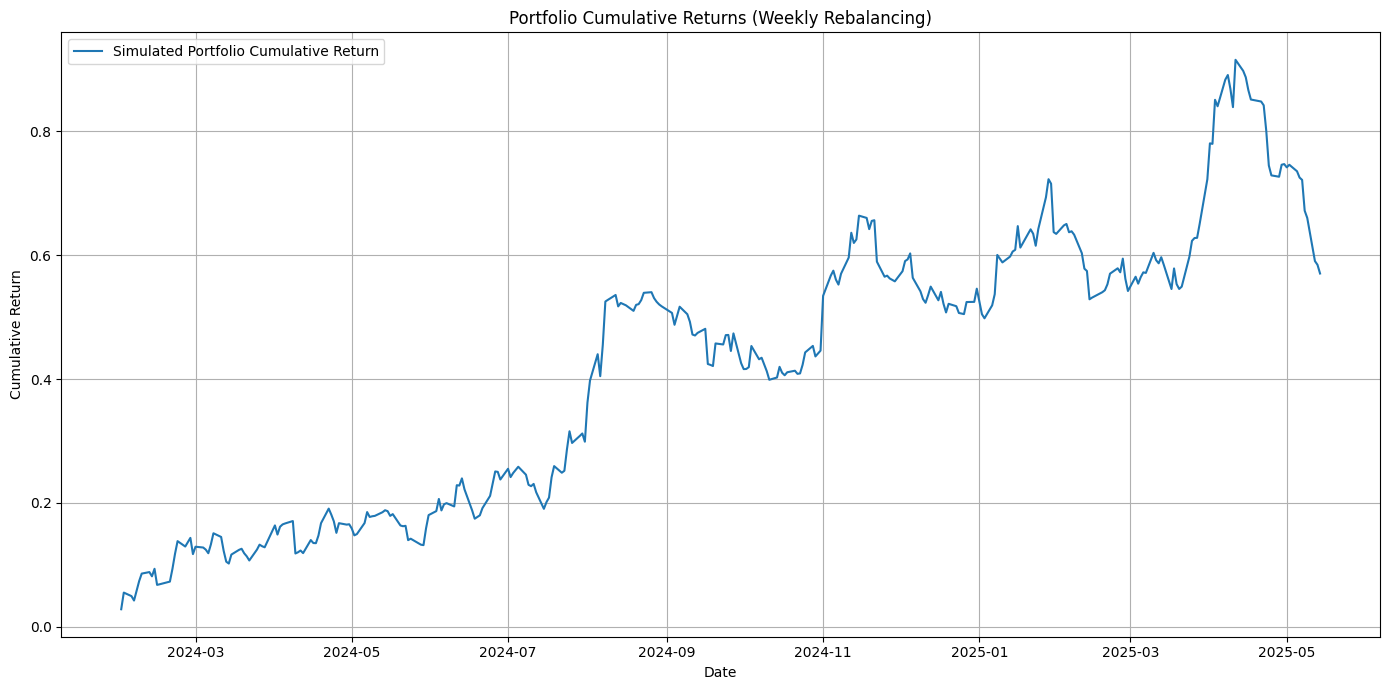

In [141]:
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns.index, cumulative_returns.values, label='Simulated Portfolio Cumulative Return')
plt.title('Portfolio Cumulative Returns (Weekly Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

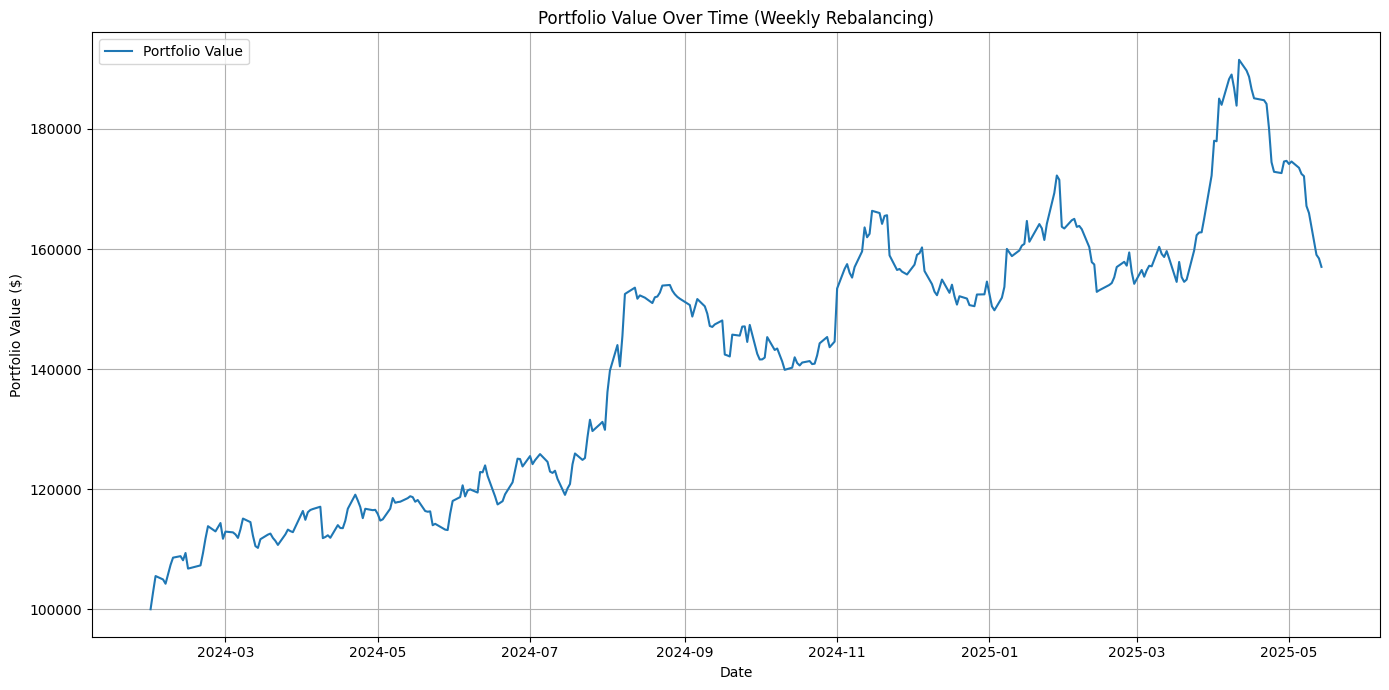

In [142]:
plt.figure(figsize=(14, 7))
# Use 'portfolio_value_history' from the performance_metrics dictionary
plt.plot(performance_metrics['portfolio_value_history'].index, performance_metrics['portfolio_value_history'].values, label='Portfolio Value')
plt.title('Portfolio Value Over Time (Weekly Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

In [143]:
market_returns

Date
2024-01-03   -0.008016
2024-01-04   -0.003428
2024-01-05    0.001826
2024-01-08    0.014115
2024-01-09   -0.001478
                ...   
2025-05-08    0.005800
2025-05-09   -0.000711
2025-05-12    0.032559
2025-05-13    0.007248
2025-05-14    0.001024
Name: ^GSPC, Length: 342, dtype: float64

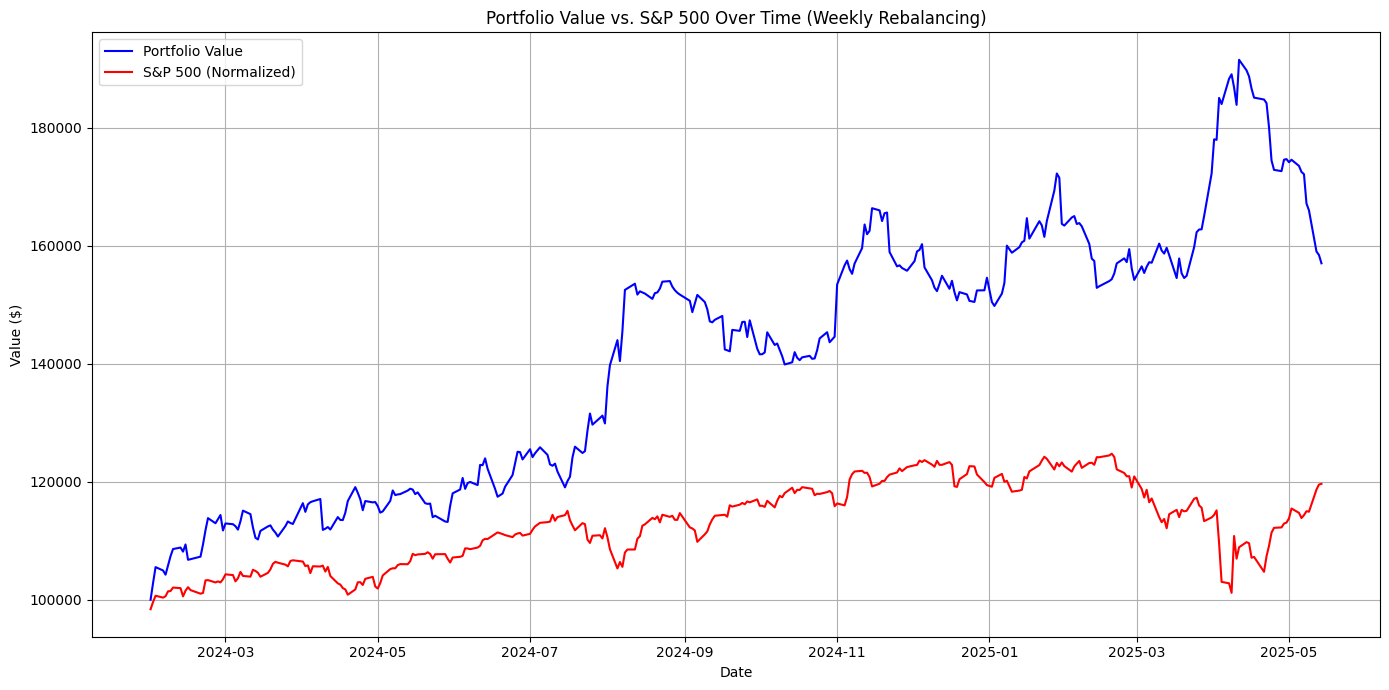

In [144]:
market_returns_aligned_to_portfolio = market_returns.reindex(
    performance_metrics['portfolio_value_history'].index, method='ffill'
)

market_returns_aligned_to_portfolio = market_returns_aligned_to_portfolio.dropna()

market_portfolio_values = my_initial_capital * (1 + market_returns_aligned_to_portfolio).cumprod()

common_index = performance_metrics['portfolio_value_history'].index.intersection(market_portfolio_values.index)

portfolio_value_aligned = performance_metrics['portfolio_value_history'].loc[common_index]
sp500_normalized_value_aligned = market_portfolio_values.loc[common_index]

plt.figure(figsize=(14, 7))

# Plot Portfolio Value
plt.plot(portfolio_value_aligned.index, portfolio_value_aligned.values, label='Portfolio Value', color='blue')

# Overlay S&P 500 Return
plt.plot(sp500_normalized_value_aligned.index, sp500_normalized_value_aligned.values, label='S&P 500 (Normalized)', color='red')

plt.title('Portfolio Value vs. S&P 500 Over Time (Weekly Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

In [145]:
# Sector based clustering and investing

In [146]:
# --- Helper Function: Get Long/Short Stocks by Sector ---
# This function is analogous to _get_long_short_stocks_for_window but for sectors.
def _get_long_short_stocks_by_sector_for_window(
    current_residuals_window_data: pd.DataFrame, # Residuals for the lookback window
    stock_sectors_map: pd.Series,              # Map of stock -> sector
    num_top_sectors: int,                      # How many top sectors to short
    num_bottom_sectors: int,                   # How many bottom sectors to long
    proportion_to_invest: float                # Proportion of stocks within selected sectors
) -> (list, list):

    # Ensure stock_sectors_map aligns with stocks in current_residuals_window_data
    available_stocks_in_window = current_residuals_window_data.columns
    aligned_stock_sectors_map = stock_sectors_map.loc[available_stocks_in_window].dropna()

    if aligned_stock_sectors_map.empty:
        return [], [] # No stocks with sector data in this window

    # 1. Calculate Individual Stock Average Residual Returns for this window
    individual_stock_avg_residuals_window = current_residuals_window_data.mean()
    individual_stock_avg_residuals_window.name = 'Avg_Residual_Return'

    # 2. Combine individual stock residuals with their sectors
    stock_details_window = aligned_stock_sectors_map.to_frame().join(
        individual_stock_avg_residuals_window, how='inner'
    )
    
    # 3. Calculate Average Residual Return for Each Sector
    sector_avg_residuals = stock_details_window.groupby('Sector')['Avg_Residual_Return'].mean()

    # 4. Identify Top/Bottom Sectors
    available_sectors = len(sector_avg_residuals)
    actual_num_top_sectors = min(num_top_sectors, available_sectors // 2)
    actual_num_bottom_sectors = min(num_bottom_sectors, available_sectors - actual_num_top_sectors)

    if actual_num_top_sectors == 0 and actual_num_bottom_sectors == 0:
        return [], []

    sorted_sectors = sector_avg_residuals.sort_values(ascending=False)

    filtered_overperformer = sorted_sectors[sorted_sectors.values > 0]
    filtered_underperformer = sorted_sectors[sorted_sectors.values < 0]

    overperformer_sector_names = filtered_overperformer.head(actual_num_top_sectors).index.tolist()
    underperformer_sector_names = filtered_underperformer.tail(actual_num_bottom_sectors).index.tolist()


    final_long_stocks = []
    final_short_stocks = []

    # 5. Select Proportion of Stocks *Within* Identified Sectors
    # Process consistently bad Sectors (for short Positions)
    for sector_name in underperformer_sector_names:
        stocks_in_this_sector = stock_details_window[stock_details_window['Sector'] == sector_name]
        ranked_stocks = stocks_in_this_sector.sort_values(by='Avg_Residual_Return', ascending=False) # Longing best within good sector
        num_to_select = int(len(ranked_stocks) * proportion_to_invest)
        if num_to_select == 0 and len(ranked_stocks) > 0: num_to_select = 1
        final_long_stocks.extend(ranked_stocks.head(num_to_select).index.tolist())

    # Process consistently good Sectors (for long Positions)
    for sector_name in overperformer_sector_names:
        stocks_in_this_sector = stock_details_window[stock_details_window['Sector'] == sector_name]
        ranked_stocks = stocks_in_this_sector.sort_values(by='Avg_Residual_Return', ascending=True) # Shorting worst within bad sector
        num_to_select = int(len(ranked_stocks) * proportion_to_invest)
        if num_to_select == 0 and len(ranked_stocks) > 0: num_to_select = 1
        final_short_stocks.extend(ranked_stocks.head(num_to_select).index.tolist())
        
    return final_long_stocks, final_short_stocks


# --- Main Simulation Function for Sector-Based Strategy ---
def simulate_sector_based_portfolio(
    residuals: pd.DataFrame,
    stock_returns: pd.DataFrame,
    stock_sectors_df: pd.DataFrame, # NEW: DataFrame with stock sectors
    
    # Simulation Parameters (similar to cluster-based)
    lookback_window_days: int,
    rebalance_frequency_days: int,
    num_top_sectors: int,          # NEW: Number of top sectors to short
    num_bottom_sectors: int,       # NEW: Number of bottom sectors to long
    proportion_to_invest: float,
    initial_capital: float,
    
    # Performance Metrics Parameters
    risk_free_rate_annual: float = 0.02,
    num_trading_days_in_year: int = 252,
    verbose: bool = True
) -> (pd.Series, dict):

    # --- 1. Data Alignment and Preparation ---
    # Ensure all three inputs (residuals, stock_returns, stock_sectors_df) are aligned
    common_dates = residuals.index.intersection(stock_returns.index)
    common_stocks = residuals.columns.intersection(stock_returns.columns).intersection(stock_sectors_df.index)

    residuals = residuals.loc[common_dates, common_stocks].copy()
    stock_returns = stock_returns.loc[common_dates, common_stocks].copy()
    stock_sectors_map = stock_sectors_df.loc[common_stocks, 'Sector'].copy() # Ensure it's a Series with 'Sector' column

    all_dates = residuals.index
    num_full_days = len(all_dates)
    num_stocks = len(common_stocks)

    if verbose:
        print("--- Starting Sector-Based Portfolio Simulation ---")
        print(f"Full data period: {all_dates.min().strftime('%Y-%m-%d')} to {all_dates.max().strftime('%Y-%m-%d')}")
        print(f"Total stocks available: {num_stocks}")
        print(f"Strategy config: Lookback={lookback_window_days}d, Rebalance={rebalance_frequency_days}d, Top Sectors={num_top_sectors}, Bottom Sectors={num_bottom_sectors}, Invest_Prop={proportion_to_invest*100:.0f}%")
        print("-" * 60)

    # --- 2. Determine Rebalancing Dates ---
    first_rebalance_idx = all_dates.get_loc(all_dates[0]) + lookback_window_days
    
    if first_rebalance_idx >= num_full_days:
        if verbose: print("Error: Not enough historical data for even the first lookback window. Adjust 'lookback_window_days' or data range.")
        return pd.Series(), {}

    rebalance_dates_indices = np.arange(first_rebalance_idx, num_full_days, rebalance_frequency_days)
    rebalance_dates = all_dates[rebalance_dates_indices].tolist()

    if verbose:
        print(f"Simulation will run from {all_dates[first_rebalance_idx].strftime('%Y-%m-%d')} to {all_dates.max().strftime('%Y-%m-%d')}")
        print(f"First rebalance on: {rebalance_dates[0].strftime('%Y-%m-%d')}")
        print(f"Last rebalance on: {rebalance_dates[-1].strftime('%Y-%m-%d')}")
        print("-" * 60)

    # --- 3. Initialize Portfolio Tracking ---
    portfolio_daily_returns_list = []
    portfolio_values_history = [initial_capital]
    current_portfolio_value = initial_capital

    current_long_stocks = []
    current_short_stocks = []
    
    # --- 4. Main Simulation Loop ---
    for i in range(first_rebalance_idx, num_full_days):
        current_date = all_dates[i]
        
        # --- Check for Rebalancing ---
        if current_date in rebalance_dates:
            if verbose: print(f"\n--- Rebalancing on: {current_date.strftime('%Y-%m-%d')} ---")
            
            # Define the lookback window for this rebalance
            window_start_date_idx = all_dates.get_loc(current_date) - lookback_window_days
            window_start_date = all_dates[max(0, window_start_date_idx)]

            current_residuals_window = residuals.loc[window_start_date:current_date].copy()
            current_residuals_window = current_residuals_window.dropna(axis=1, how='all')

            # Run the sector-based selection pipeline
            new_long_stocks, new_short_stocks = _get_long_short_stocks_by_sector_for_window(
                current_residuals_window_data=current_residuals_window,
                stock_sectors_map=stock_sectors_map,
                num_top_sectors=num_top_sectors,
                num_bottom_sectors=num_bottom_sectors,
                proportion_to_invest=proportion_to_invest
            )
            
            # Update current positions
            current_long_stocks = new_long_stocks
            current_short_stocks = new_short_stocks
            
            if verbose: print(f"  Longing {len(current_long_stocks)} stocks and Shorting {len(current_short_stocks)} stocks.")
            
        # --- Calculate Daily Portfolio Return ---
        daily_portfolio_return = 0.0
        
        if current_long_stocks or current_short_stocks:
            today_returns = stock_returns.loc[current_date]
            
            if current_long_stocks:
                long_weight_per_stock = 1 / len(current_long_stocks)
                for stock_ticker in current_long_stocks:
                    if stock_ticker in today_returns.index:
                        daily_portfolio_return -= today_returns.loc[stock_ticker] * long_weight_per_stock
            
            if current_short_stocks:
                short_weight_per_stock = 1 / len(current_short_stocks)
                for stock_ticker in current_short_stocks:
                    if stock_ticker in today_returns.index:
                        daily_portfolio_return += today_returns.loc[stock_ticker] * short_weight_per_stock

        portfolio_daily_returns_list.append(daily_portfolio_return)
        current_portfolio_value *= (1 + daily_portfolio_return)
        portfolio_values_history.append(current_portfolio_value)

    if verbose: print("\n--- Simulation Complete ---")

    # --- 5. Final Analysis and Return ---
    portfolio_daily_returns_series = pd.Series(portfolio_daily_returns_list, index=all_dates[first_rebalance_idx:])
    cumulative_portfolio_returns = (1 + portfolio_daily_returns_series).cumprod() - 1

    annualized_return = (1 + portfolio_daily_returns_series.mean())**num_trading_days_in_year - 1
    annualized_volatility = portfolio_daily_returns_series.std() * np.sqrt(num_trading_days_in_year)
    
    sharpe_ratio = (annualized_return - risk_free_rate_annual) / annualized_volatility if annualized_volatility != 0 else np.nan

    performance_metrics = {
        'total_return': cumulative_portfolio_returns.iloc[-1],
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'portfolio_value_history': pd.Series(portfolio_values_history, index=all_dates[first_rebalance_idx-1:]),
        'daily_returns_series': portfolio_daily_returns_series
    }

    if verbose:
        print("\n--- Portfolio Performance Metrics ---")
        print(f"Total Portfolio Return: {performance_metrics['total_return']:.4f}")
        print(f"Annualized Portfolio Return: {performance_metrics['annualized_return']:.4f}")
        print(f"Annualized Portfolio Volatility: {performance_metrics['annualized_volatility']:.4f}")
        print(f"Sharpe Ratio (assuming {risk_free_rate_annual*100:.1f}% risk-free rate): {performance_metrics['sharpe_ratio']:.4f}")
        print("-" * 60)

    return cumulative_portfolio_returns, performance_metrics

--- Starting Sector-Based Portfolio Simulation ---
Full data period: 2024-01-03 to 2025-05-14
Total stocks available: 499
Strategy config: Lookback=20d, Rebalance=5d, Top Sectors=2, Bottom Sectors=1, Invest_Prop=50%
------------------------------------------------------------
Simulation will run from 2024-02-01 to 2025-05-14
First rebalance on: 2024-02-01
Last rebalance on: 2025-05-13
------------------------------------------------------------

--- Rebalancing on: 2024-02-01 ---
  Longing 5 stocks and Shorting 45 stocks.

--- Rebalancing on: 2024-02-08 ---
  Longing 5 stocks and Shorting 24 stocks.

--- Rebalancing on: 2024-02-15 ---
  Longing 21 stocks and Shorting 49 stocks.

--- Rebalancing on: 2024-02-23 ---
  Longing 21 stocks and Shorting 49 stocks.

--- Rebalancing on: 2024-03-01 ---
  Longing 21 stocks and Shorting 48 stocks.

--- Rebalancing on: 2024-03-08 ---
  Longing 21 stocks and Shorting 46 stocks.

--- Rebalancing on: 2024-03-15 ---
  Longing 21 stocks and Shorting 45 s

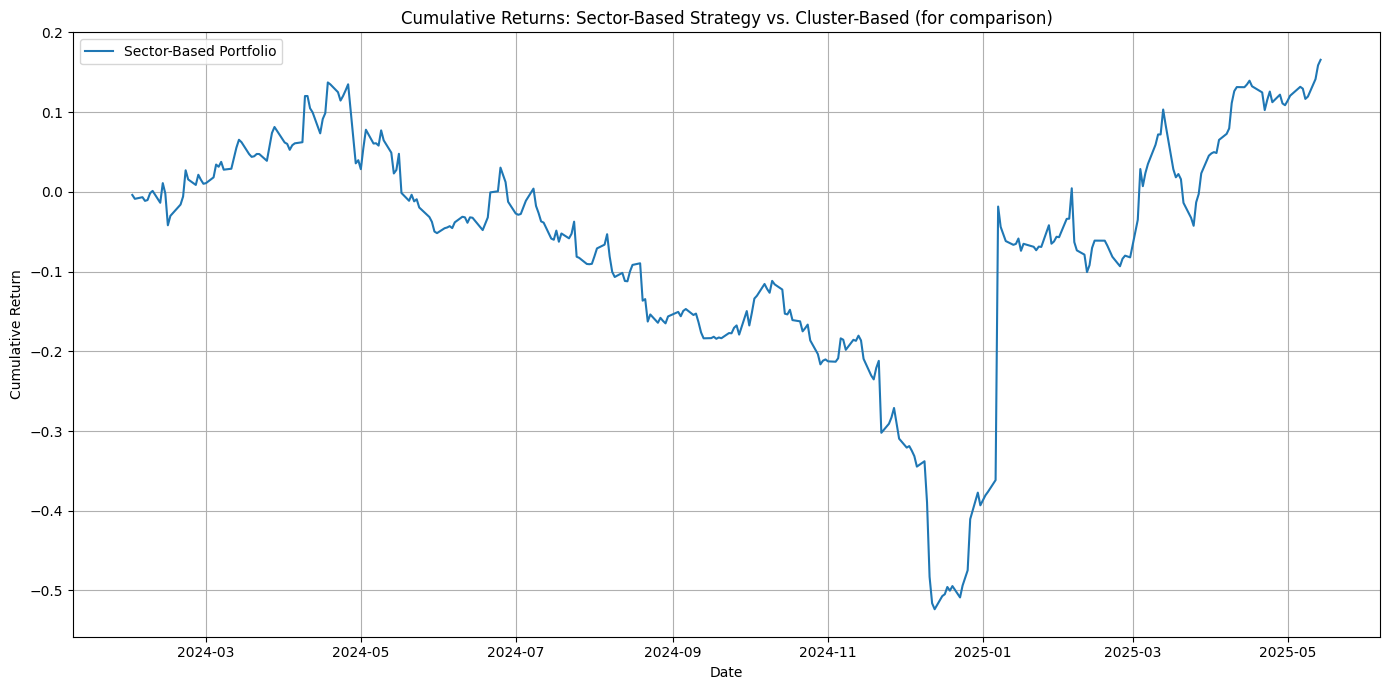


--- Comparison of Annualized Returns ---
Sector-Based Annualized Return:  0.3066


In [147]:
# Define sector-specific parameters
my_num_top_sectors = 2    # Number of top sectors to long
my_num_bottom_sectors = 1 # Number of bottom sectors to short

# Call the sector-based simulation function
cumulative_returns_sector, performance_metrics_sector = simulate_sector_based_portfolio(
    residuals=residuals,
    stock_returns=stock_returns,
    stock_sectors_df=sector_stocks_cleaned, # Pass your sector data here

    lookback_window_days=my_lookback_window_days,
    rebalance_frequency_days=my_rebalance_frequency_days,
    num_top_sectors=my_num_top_sectors,
    num_bottom_sectors=my_num_bottom_sectors,
    proportion_to_invest=my_proportion_to_invest,
    initial_capital=my_initial_capital,

    verbose=True
)

# --- Now you can compare the results ---
# Call your cluster-based simulation function as well for comparison
# cumulative_returns_cluster, performance_metrics_cluster = simulate_rebalancing_portfolio(...)

# Plotting both for comparison
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns_sector.index, cumulative_returns_sector.values, label='Sector-Based Portfolio')
# plt.plot(cumulative_returns_cluster.index, cumulative_returns_cluster.values, label='Cluster-Based Portfolio') # Uncomment to plot both
plt.title('Cumulative Returns: Sector-Based Strategy vs. Cluster-Based (for comparison)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- Comparison of Annualized Returns ---")
# print(f"Cluster-Based Annualized Return: {performance_metrics_cluster['annualized_return']:.4f}")
print(f"Sector-Based Annualized Return:  {performance_metrics_sector['annualized_return']:.4f}")

In [148]:
performance_metrics_sector['portfolio_value_history']

Date
2024-01-31    100000.000000
2024-02-01     99611.059782
2024-02-02     99124.915767
2024-02-05     99330.205097
2024-02-06     98868.443266
                  ...      
2025-05-08    111658.073492
2025-05-09    111949.996350
2025-05-12    114138.209474
2025-05-13    115874.399963
2025-05-14    116563.480689
Length: 323, dtype: float64

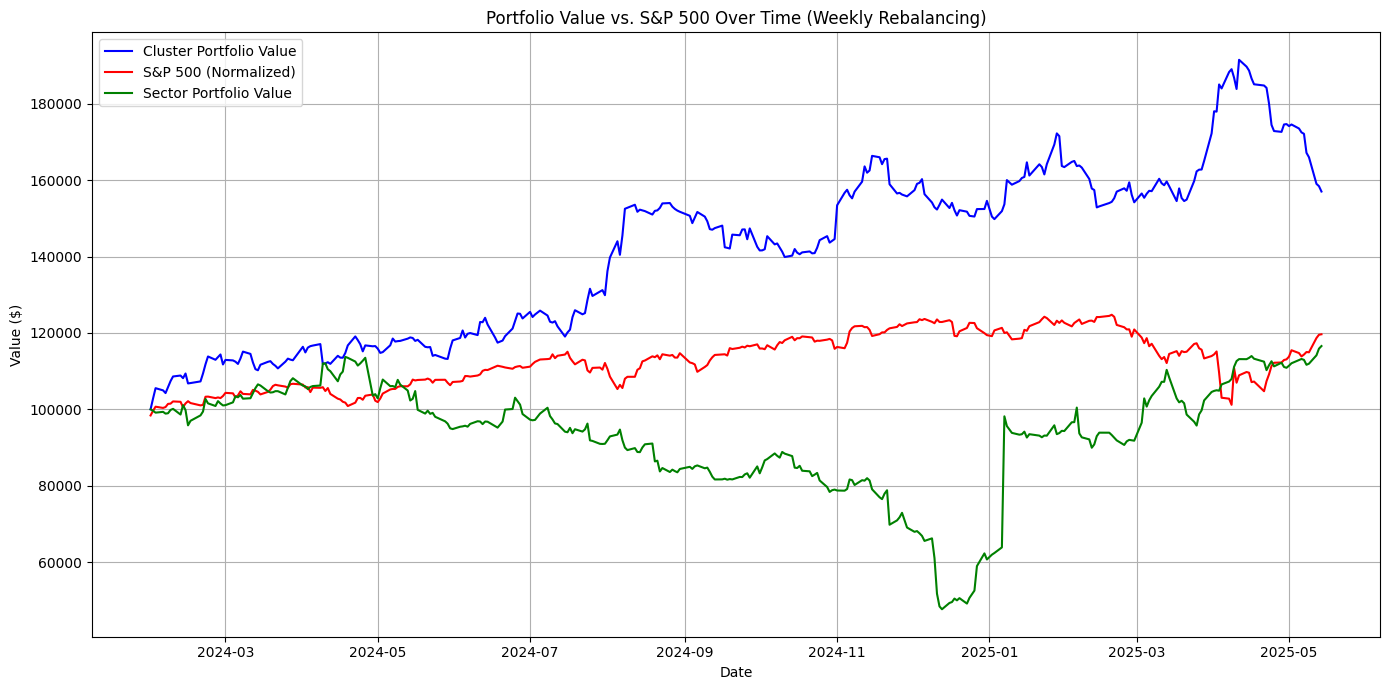

In [149]:
plt.figure(figsize=(14, 7))

# Plot Portfolio Value
plt.plot(portfolio_value_aligned.index, portfolio_value_aligned.values, label='Cluster Portfolio Value', color='blue')

# Overlay S&P 500 Return
plt.plot(sp500_normalized_value_aligned.index, sp500_normalized_value_aligned.values, label='S&P 500 (Normalized)', color='red')

plt.plot(performance_metrics_sector['portfolio_value_history'].index, performance_metrics_sector['portfolio_value_history'].values, label='Sector Portfolio Value', color='green')

plt.title('Portfolio Value vs. S&P 500 Over Time (Weekly Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
